# Analysis of Policy Claims in Academic Abstracts

This notebook analyzes the classified abstracts to explore trends in policy claims over time and across different academic journals.

# 1. Setup and Configuration

First, we import the necessary libraries and set up the key configuration variables for our analysis. **Please edit these variables to match your file paths and column names.**

We also load the dataset and prepare it for analysis e.g., creating a numeric version of our policy claim variable

In [96]:
%matplotlib inline
import matplotlib as mpl
print(mpl.get_backend())  

module://matplotlib_inline.backend_inline


In [97]:
!pip install \
  "numpy==1.25" \
  "pandas==2.0.3" \
  "scipy==1.11.4" \
  "matplotlib==3.7.3" \
  "ydata-profiling==4.6.1" \
  seaborn statsmodels nltk ipywidgets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- CONFIGURATION --- #

# 1. Path to your final classified data file (from the previous script)
INPUT_FILE = "../data/json_files/filtered/all_abstracts_LLM.csv" # Or .json

# 2. The column containing the boolean classification (True/False)
CLAIM_COLUMN = "llm_policy_claim"

# 3. The column for stratifying by journal (replace if yours is different)
JOURNAL_COLUMN = "journal"

# 4. The column for the publication year
YEAR_COLUMN = "publication_year"

# --- LOAD DATA --- #
if INPUT_FILE.endswith('.csv'):
    df = pd.read_csv(INPUT_FILE)
elif INPUT_FILE.endswith('.json'):
    df = pd.read_json(INPUT_FILE)
else:
    raise ValueError("Input file must be a .csv or .json file")

print(f"Loaded {len(df)} records before cleaning.")

# DROP ROWS WHERE llm_policy_claim IS MISSING
df = df.dropna(subset=[CLAIM_COLUMN])
print(f"After removing missing {CLAIM_COLUMN}: {len(df)} records remain.")

# Standardize journal names to title case for consistency
df[JOURNAL_COLUMN] = df[JOURNAL_COLUMN].str.title()

# Create a numeric 'claim' column (1 for True, 0 for False) for easy calculations
df['claim'] = (df[CLAIM_COLUMN] == True).astype(int)

print(f"Final dataset: {len(df)} records.")
df.head()

Loaded 45808 records before cleaning.
After removing missing llm_policy_claim: 45807 records remain.
Final dataset: 45807 records.


,scopus_id,doi,title,journal,publication_year,keywords,abstract,article_type,corresponding_author_country,cited_by_count,llm_policy_claim,claim
0,SCOPUS_ID:0025248647,NaN,"Epidemic dengue 1 in Brazil, 1986: Evaluation ...",American Journal Of Epidemiology,1990,"['Dengue', 'Enzyme-linked immunosorbent assay'...","In the last 15 years, dengue fever has emerged...",article,United States,61,True,1
1,SCOPUS_ID:0025695891,10.1093/oxfordjournals.aje.a115759,The validity of questionnaire reports of a his...,American Journal Of Epidemiology,1990,"['Epidemiologic methods', 'Otitis media', 'Que...","A random sample of 2,512 children with an esti...",article,Finland,53,False,0
2,SCOPUS_ID:0025695889,10.1093/oxfordjournals.aje.a115751,The relation between body mass index and plasm...,American Journal Of Epidemiology,1990,"['Body weight', 'Child', 'Cholesterol', 'Chron...",The relation between body mass index expressed...,article,United States,36,False,0
3,SCOPUS_ID:0025690158,10.1093/oxfordjournals.aje.a115757,The strong heart study a study of cardiovascul...,American Journal Of Epidemiology,1990,"['Cardiovascular disease', 'Indians, North Ame...",Available data indicate that cardiovascular di...,article,United States,528,False,0
4,SCOPUS_ID:0025681563,10.1093/oxfordjournals.aje.a115761,The effects of measurement errors on relatwe r...,American Journal Of Epidemiology,1990,"['Regression analysis', 'Risk', 'Statistics']",This paper concerns the effects of random erro...,article,Canada,204,False,0


## install packages...

In [98]:
# --- ENVIRONMENT CHECK ---
import sys
import subprocess

print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version}")

# --- REQUIRED PACKAGES ---
required = [
    "pandas", "numpy", "matplotlib", "seaborn", "ydata_profiling", "statsmodels", "nltk"
]
for pkg in required:
    try:
        __import__(pkg)
        print(f"✓ {pkg} installed")
    except ImportError:
        print(f"✗ {pkg} NOT installed. Run: pip install {pkg}")

# If you want to auto-install missing packages, uncomment below:
for pkg in required:
    try:
        __import__(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])


# Print Python interpreter and version
import sys
print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version}")

Python executable: /Users/wangmengyao/Desktop/policyclaims/.venv/bin/python
Python version: 3.10.18 (main, Jun  3 2025, 18:23:41) [Clang 17.0.0 (clang-1700.0.13.3)]
✓ pandas installed
✓ numpy installed
✓ matplotlib installed
✓ seaborn installed
✓ ydata_profiling installed
✓ statsmodels installed
✓ nltk installed
Python executable: /Users/wangmengyao/Desktop/policyclaims/.venv/bin/python
Python version: 3.10.18 (main, Jun  3 2025, 18:23:41) [Clang 17.0.0 (clang-1700.0.13.3)]


## simple sense checks of data cross-tabs etc, by year and journal.... 

In [99]:
#simple cross-tabs, by year and journal.... 
# Percent policy claim by year
year_pct = df.groupby('publication_year')['llm_policy_claim'].mean() * 100
print(year_pct)

# Percent policy claim by journal
journal_pct = df.groupby('journal')['llm_policy_claim'].mean() * 100
print(journal_pct)

publication_year
1990    12.529002
1991    16.831683
1992    13.807531
1993    19.194062
1994    18.492462
1995    17.913386
1996    18.333333
1997     17.70918
1998    19.915612
1999    19.777601
2000    19.781079
2001    20.093095
2002    19.519833
2003    21.190893
2004    23.592085
2005    23.298639
2006    23.184818
2007     23.73255
2008    23.606811
2009     28.33217
2010    27.233429
2011    24.826147
2012    26.134056
2013    28.156491
2014    25.160163
2015    28.199189
2016    27.449514
2017    32.168285
2018     32.31821
2019    32.163743
2020     34.90991
2021    36.384705
2022    36.730889
2023    34.557235
2024     36.23298
Name: llm_policy_claim, dtype: object
journal
American Journal Of Epidemiology                 9.892744
American Journal Of Preventive Medicine         38.145721
American Journal Of Public Health               33.674907
Epidemiology                                     3.683536
European Journal Of Epidemiology                14.397906
European Journal 

In [100]:
# Tabulate % True, False, and missing for a column - note n=1 is missing
col = 'llm_policy_claim'
tab = df[col].value_counts(dropna=False, normalize=False) 
print(tab)

llm_policy_claim
False    34072
True     11735
Name: count, dtype: int64


In [101]:
# sense check: Check unique journal names and count - in case of spelling inconsistencies. should be n=10 journals
print('JOURNAL_COLUMN variable:', JOURNAL_COLUMN)
print('Unique journal names in DataFrame:')
print(df[JOURNAL_COLUMN].unique())
print('Number of unique journals:', df[JOURNAL_COLUMN].nunique())

# New: Inspect and standardize corresponding_author_country
print('\n--- Corresponding author country check ---')
if 'corresponding_author_country' in df.columns:
    # Raw counts as DataFrame with column named 'N'
    raw_counts = df['corresponding_author_country'].value_counts(dropna=False)
    raw_counts_df = raw_counts.reset_index().rename(columns={'index': 'country', 'corresponding_author_country': 'N'})
    print('Value counts (raw):')
    print(raw_counts_df.head(50).to_string(index=False))

    # Standardize: strip whitespace, convert to upper case, treat empty strings and nulls as UNKNOWN
    df['corresponding_author_country'] = (
        df['corresponding_author_country']
        .astype(str)
        .str.strip()
        .replace({'nan': None})
    )
    df['corresponding_author_country'] = (
        df['corresponding_author_country']
        .fillna('UNKNOWN')
        .replace({'': 'UNKNOWN'})
        .str.upper()
    )

    # Standardized counts as DataFrame with column 'N'
    std_counts = df['corresponding_author_country'].value_counts()
    std_counts_df = std_counts.reset_index().rename(columns={'index': 'country', 'corresponding_author_country': 'N'})
    print('\nAfter standardization:')
    print(std_counts_df.head(50).to_string(index=False))

    # Number of unique countries
    print('\nNumber of unique countries (N):', df['corresponding_author_country'].nunique())
else:
    print('Column "corresponding_author_country" not found in dataframe')

JOURNAL_COLUMN variable: journal
Unique journal names in DataFrame:
['American Journal Of Epidemiology'
 'American Journal Of Preventive Medicine'
 'American Journal Of Public Health' 'Epidemiology'
 'European Journal Of Epidemiology' 'European Journal Of Public Health'
 'International Journal Of Epidemiology'
 'Journal Of Epidemiology And Community Health' 'The Lancet Public Health'
 'Preventive Medicine']
Number of unique journals: 10

--- Corresponding author country check ---
Value counts (raw):
                 N  count
     United States  23417
    United Kingdom   4033
            Canada   1665
       Netherlands   1608
         Australia   1370
            Sweden   1201
            France   1108
             Spain    998
           Denmark    965
           Finland    936
             Italy    895
           Germany    740
             China    718
             Japan    613
            Norway    610
           Unknown    356
       Switzerland    348
           Belgium    284
 

# Table 1: Key Characteristics of the Dataset

This table provides a high-level summary of the entire dataset, including the total number of articles, the overall rate of policy claims, and the diversity of journals and countries represented.

In [102]:
import pandas as pd
import numpy as np

# Define time periods with accurate labels
periods = {
    '1990-1999': (1990, 2000),
    '2000-2009': (2000, 2010),
    '2010-2019': (2010, 2020),
    '2020-2024': (2020, 2025),
    'All years': (1990, 2025)
}

# Get top 10 journals by article count
top_10_journals = df['journal'].value_counts().head(10).index.tolist()

# Calculate policy claim rates for 2020-2024 to sort journals
period_2020_df = df[(df['publication_year'] >= 2020) & (df['publication_year'] < 2025)]
journal_policy_rates = {}

for journal in top_10_journals:
    journal_df = period_2020_df[period_2020_df['journal'] == journal]
    n_journal_articles = len(journal_df)
    
    if n_journal_articles > 0:
        journal_policy_claims = (journal_df['claim'] == 1).sum()
        pct_journal_policy = (journal_policy_claims / n_journal_articles * 100)
        journal_policy_rates[journal] = pct_journal_policy
    else:
        journal_policy_rates[journal] = 0

# Sort journals by policy claim rate (ascending, so lowest first, highest last)
sorted_journals = sorted(journal_policy_rates.keys(), key=lambda x: journal_policy_rates[x])

# Get top 15 countries by publication count
top_15_countries = df['corresponding_author_country'].value_counts().head(15).index.tolist()

# Calculate policy claim rates for 2020-2024 to sort countries
country_policy_rates = {}

for country in top_15_countries:
    country_df = period_2020_df[period_2020_df['corresponding_author_country'] == country]
    n_country_articles = len(country_df)
    
    if n_country_articles > 0:
        country_policy_claims = (country_df['claim'] == 1).sum()
        pct_country_policy = (country_policy_claims / n_country_articles * 100)
        country_policy_rates[country] = pct_country_policy
    else:
        country_policy_rates[country] = 0

# Sort countries by policy claim rate (ascending, so lowest first, highest last)
sorted_countries = sorted(country_policy_rates.keys(), key=lambda x: country_policy_rates[x])

# Initialize results dictionary
results = {}
row_names = []
categories = []

# Metrics to calculate
metrics = [
    'Number of articles, N',
    'Number of unique journals, N',
    'Words in abstracts, mean (SD)',
    'Papers with keywords included, %',
    'Countries of corresponding author, N',
    'Policy claims, N (%)'
]

# Initialize results structure for base metrics
for metric in metrics:
    results[metric] = {}
    row_names.append(metric)
    categories.append('')

# Add "All journals/countries" row
results['  All journals/countries'] = {}
row_names.append('  All journals/countries')
categories.append('')

# Add journal heading
results['Journals'] = {}
row_names.append('Journals')
categories.append('Journal')

# Initialize results structure for journal-specific metrics (in sorted order)
for i, journal in enumerate(sorted_journals):
    results[f'  {journal}'] = {}
    row_names.append(f'  {journal}')
    categories.append('Journal')

# Add country heading
results['Countries'] = {}
row_names.append('Countries')
categories.append('Country')

# Initialize results structure for country-specific metrics (in sorted order)
for i, country in enumerate(sorted_countries):
    # Format country name: capitalize first letter only
    country_formatted = country.capitalize() if isinstance(country, str) else country
    results[f'  {country_formatted}'] = {}
    row_names.append(f'  {country_formatted}')
    categories.append('Country')

# Calculate metrics for each period
for period_name, (start_year, end_year) in periods.items():
    # Filter data for the period
    period_df = df[(df['publication_year'] >= start_year) & (df['publication_year'] < end_year)]
    
    # Number of articles
    n_articles = len(period_df)
    results['Number of articles, N'][period_name] = n_articles
    
    # Number of unique journals
    results['Number of unique journals, N'][period_name] = period_df['journal'].nunique()
    
    # Words in abstracts - calculate word count for each abstract
    word_counts = period_df['abstract'].fillna('').str.split().str.len()
    mean_words = word_counts.mean()
    sd_words = word_counts.std()
    results['Words in abstracts, mean (SD)'][period_name] = f"{mean_words:.1f} ({sd_words:.1f})" if not pd.isna(mean_words) else "N/A"
    
    # Papers with keywords included (not null, not empty list, not empty string)
    def has_keywords(x):
        if pd.isna(x):
            return False
        if isinstance(x, list) and len(x) == 0:
            return False
        if isinstance(x, str) and (x.strip() == '' or x.strip() == '[]'):
            return False
        return True
    
    papers_with_keywords = period_df['keywords'].apply(has_keywords).sum()
    pct_with_keywords = (papers_with_keywords / n_articles * 100) if n_articles > 0 else 0
    results['Papers with keywords included, %'][period_name] = f"{pct_with_keywords:.1f}"
    
    # Countries of corresponding author - count unique countries
    results['Countries of corresponding author, N'][period_name] = period_df['corresponding_author_country'].nunique()
    
    # Policy claims - count papers where claim == 1
    papers_with_policy = (period_df['claim'] == 1).sum()
    pct_policy = (papers_with_policy / n_articles * 100) if n_articles > 0 else 0
    results['Policy claims, N (%)'][period_name] = f"{papers_with_policy} ({pct_policy:.1f})"
    
    # All journals/countries % policy claims
    results['  All journals/countries'][period_name] = f"{pct_policy:.1f}"
    
    # Journal heading (empty)
    results['Journals'][period_name] = ""
    
    # Calculate policy claim percentages for each of the top 10 journals (in sorted order)
    for journal in sorted_journals:
        journal_df = period_df[period_df['journal'] == journal]
        n_journal_articles = len(journal_df)
        
        if n_journal_articles > 0:
            journal_policy_claims = (journal_df['claim'] == 1).sum()
            pct_journal_policy = (journal_policy_claims / n_journal_articles * 100)
            results[f'  {journal}'][period_name] = f"{pct_journal_policy:.1f}"
        else:
            results[f'  {journal}'][period_name] = "N/A"
    
    # Country heading (empty)
    results['Countries'][period_name] = ""
    
    # Calculate policy claim percentages for each of the top 15 countries (in sorted order)
    for country in sorted_countries:
        country_df = period_df[period_df['corresponding_author_country'] == country]
        n_country_articles = len(country_df)
        
        # Format country name: capitalize first letter only
        country_formatted = country.capitalize() if isinstance(country, str) else country
        
        if n_country_articles > 0:
            country_policy_claims = (country_df['claim'] == 1).sum()
            pct_country_policy = (country_policy_claims / n_country_articles * 100)
            results[f'  {country_formatted}'][period_name] = f"{pct_country_policy:.1f}"
        else:
            results[f'  {country_formatted}'][period_name] = "N/A"

# Create the table with correct orientation (metrics as rows, periods as columns)
table1 = pd.DataFrame(results).T

# Rename the index to remove the default "name" label
table1.index.name = None

# Create a styled version for display in Jupyter
from IPython.display import HTML

# Create HTML table with bold for Journals and Countries rows
def format_table_html(table_df, row_names):
    html = "<table border='1' cellpadding='8'><tr>"
    
    # Header row
    html += "<th></th>"
    for col in table_df.columns:
        html += f"<th>{col}</th>"
    html += "</tr>"
    
    # Data rows
    for i, row_name in enumerate(row_names):
        if row_name in ['Journals', 'Countries']:
            html += f"<tr><td><b>{row_name}</b></td>"
        else:
            html += f"<tr><td>{row_name}</td>"
        
        for col in table_df.columns:
            html += f"<td>{table_df.loc[row_names[i], col]}</td>"
        html += "</tr>"
    
    html += "</table>"
    return html

# Display the table
print("\nTable 1: Descriptive Statistics by Time Period")
print("="*120)
print(table1.to_string())

# Also display as formatted HTML in Jupyter
display(HTML(format_table_html(table1, row_names)))


Table 1: Descriptive Statistics by Time Period
                                                   1990-1999     2000-2009     2010-2019     2020-2024     All years
Number of articles, N                                  10436         12529         15464          7378         45807
Number of unique journals, N                               9             9            10            10            10
Words in abstracts, mean (SD)                   205.5 (67.5)  215.9 (55.2)  221.0 (52.0)  238.4 (57.4)  218.9 (58.5)
Papers with keywords included, %                        49.4          60.6          45.1          57.8          52.4
Countries of corresponding author, N                     112           118           121           104           153
Policy claims, N (%)                             1841 (17.6)   2857 (22.8)   4394 (28.4)   2643 (35.8)  11735 (25.6)
  All journals/countries                                17.6          22.8          28.4          35.8          25.6
Journals        

,1990-1999,2000-2009,2010-2019,2020-2024,All years
"Number of articles, N",10436,12529,15464,7378,45807
"Number of unique journals, N",9,9,10,10,10
"Words in abstracts, mean (SD)",205.5 (67.5),215.9 (55.2),221.0 (52.0),238.4 (57.4),218.9 (58.5)
"Papers with keywords included, %",49.4,60.6,45.1,57.8,52.4
"Countries of corresponding author, N",112,118,121,104,153
"Policy claims, N (%)",1841 (17.6),2857 (22.8),4394 (28.4),2643 (35.8),11735 (25.6)
All journals/countries,17.6,22.8,28.4,35.8,25.6
Journals,,,,,
Epidemiology,1.2,4.1,4.5,5.3,3.7
European Journal Of Epidemiology,19.4,15.3,10.0,14.3,14.4


In [103]:
# CSV file
import csv
cols = ['1990-1999','2000-2009','2010-2019','2020-2024','All years']
cols = [x for x in cols if x in table1.columns] + [x for x in table1.columns if x not in cols]
t = table1.copy()
t.insert(0, 'Row', t.index)
with open('../table/table1_descriptive_stats.csv', 'w', newline='') as f:
    w = csv.writer(f)
    w.writerow(['Row'] + cols)
    w.writerows(t[['Row'] + cols].to_numpy())

In [104]:
# Docs file
from docx import Document
from docx.shared import Inches
from docx.enum.table import WD_TABLE_ALIGNMENT
from docx.enum.text import WD_ALIGN_PARAGRAPH

cols = ['All years','1990-1999','2000-2009','2010-2019','2020-2024']
cols = [c for c in col if c in table1.columns] + [c for c in table1.columns if c not in col]
df = table1.loc[[r for r in row_names if r in table1.index], cols].copy()
df.insert(0, "Row", df.index)

doc = Document()
t = doc.add_table(rows=1, cols=len(df.columns), style="Table Grid")
t.alignment = WD_TABLE_ALIGNMENT.CENTER
for j,c in enumerate(df.columns): t.rows[0].cells[j].paragraphs[0].add_run(str(c)).bold=True

for i in range(len(df)):
    cells = t.add_row().cells
    for j,c in enumerate(df.columns):
        val = "" if pd.isna(df.iat[i,j]) else str(df.iat[i,j])
        p = cells[j].paragraphs[0]; r = p.add_run(val)
        if j==0:
            if val.strip() in ("Journals","Countries"): r.bold=True
            if val.startswith("  "): p.paragraph_format.left_indent = Inches(0.25)
            p.alignment = WD_ALIGN_PARAGRAPH.LEFT
        else:
            p.alignment = WD_ALIGN_PARAGRAPH.RIGHT

doc.save("../table/table1_descriptive_stats.docx")

# Fig 1 - year overall plot

In [105]:
# --- CONFIGURATION --- #

# 1. Path to your final classified data file (from the previous script)
INPUT_FILE = "../data/json_files/filtered/all_abstracts_LLM.csv" # Or .json

# 2. The column containing the boolean classification (True/False)
CLAIM_COLUMN = "llm_policy_claim"

# 3. The column for stratifying by journal (replace if yours is different)
JOURNAL_COLUMN = "journal"

# 4. The column for the publication year
YEAR_COLUMN = "publication_year"

# 5. Directory to save figures
FIGURE_DIR = Path("../figures")
FIGURE_DIR.mkdir(exist_ok=True, parents=True)

# Set a nice style for the plots
sns.set_theme(style="whitegrid")

# --- LOAD DATA --- #
if INPUT_FILE.endswith('.csv'):
    df = pd.read_csv(INPUT_FILE)
elif INPUT_FILE.endswith('.json'):
    df = pd.read_json(INPUT_FILE)
else:
    raise ValueError("Input file must be a .csv or .json file")

print(f"Loaded {len(df)} records before cleaning.")

# DROP ROWS WHERE llm_policy_claim IS MISSING
df = df.dropna(subset=[CLAIM_COLUMN])
print(f"After removing missing {CLAIM_COLUMN}: {len(df)} records remain.")

# Standardize journal names to title case for consistency
df[JOURNAL_COLUMN] = df[JOURNAL_COLUMN].str.title()

# Create a numeric 'claim' column (1 for True, 0 for False) for easy calculations
df['claim'] = (df[CLAIM_COLUMN] == True).astype(int)

print(f"Final dataset: {len(df)} records.")
df.head()

Loaded 45808 records before cleaning.
After removing missing llm_policy_claim: 45807 records remain.
Final dataset: 45807 records.


,scopus_id,doi,title,journal,publication_year,keywords,abstract,article_type,corresponding_author_country,cited_by_count,llm_policy_claim,claim
0,SCOPUS_ID:0025248647,NaN,"Epidemic dengue 1 in Brazil, 1986: Evaluation ...",American Journal Of Epidemiology,1990,"['Dengue', 'Enzyme-linked immunosorbent assay'...","In the last 15 years, dengue fever has emerged...",article,United States,61,True,1
1,SCOPUS_ID:0025695891,10.1093/oxfordjournals.aje.a115759,The validity of questionnaire reports of a his...,American Journal Of Epidemiology,1990,"['Epidemiologic methods', 'Otitis media', 'Que...","A random sample of 2,512 children with an esti...",article,Finland,53,False,0
2,SCOPUS_ID:0025695889,10.1093/oxfordjournals.aje.a115751,The relation between body mass index and plasm...,American Journal Of Epidemiology,1990,"['Body weight', 'Child', 'Cholesterol', 'Chron...",The relation between body mass index expressed...,article,United States,36,False,0
3,SCOPUS_ID:0025690158,10.1093/oxfordjournals.aje.a115757,The strong heart study a study of cardiovascul...,American Journal Of Epidemiology,1990,"['Cardiovascular disease', 'Indians, North Ame...",Available data indicate that cardiovascular di...,article,United States,528,False,0
4,SCOPUS_ID:0025681563,10.1093/oxfordjournals.aje.a115761,The effects of measurement errors on relatwe r...,American Journal Of Epidemiology,1990,"['Regression analysis', 'Risk', 'Statistics']",This paper concerns the effects of random erro...,article,Canada,204,False,0


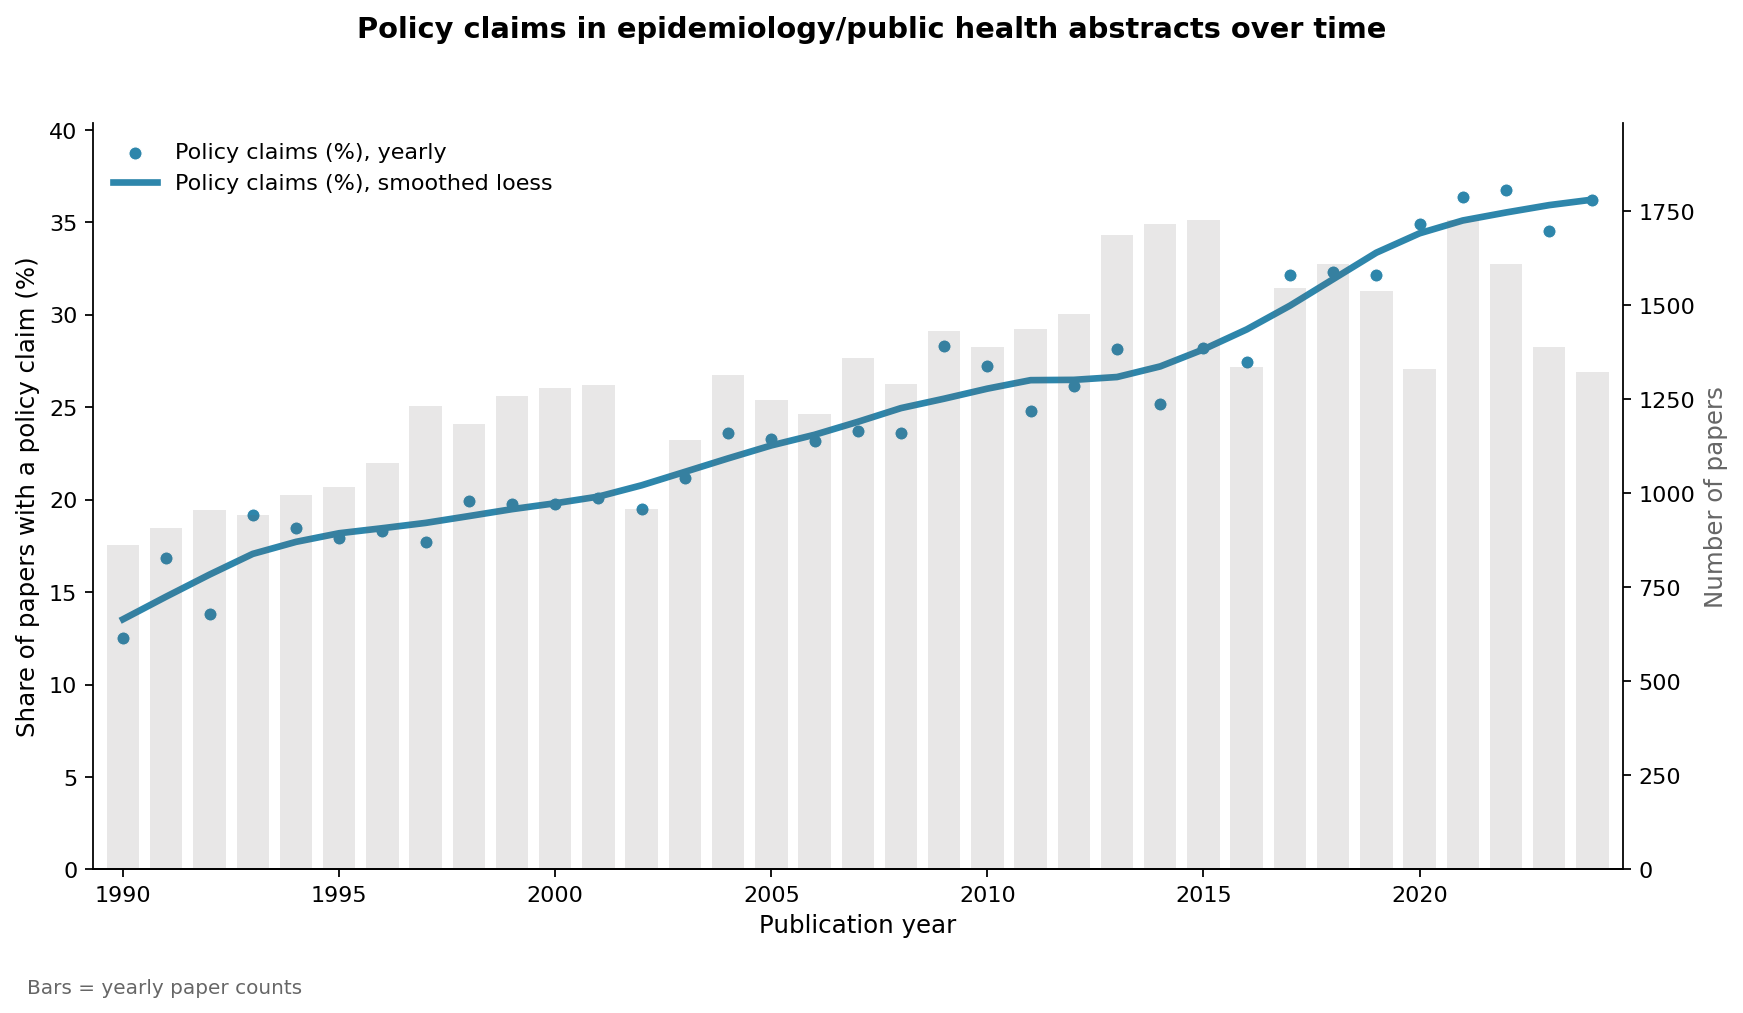

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# ---------------- Configuration ----------------

YEAR_COL = "publication_year"
CLAIM_COL = "llm_policy_claim"
YEAR_MIN, YEAR_MAX = 1990, 2024
SAVE_PATH = "../figures/fig_trend_policy_claims_loess.png"
LOESS_FRAC = 0.25   # proportion of data used for smoothing (tune 0.1–0.5)

# ---------------- Prep ----------------
if YEAR_COL not in df.columns or CLAIM_COL not in df.columns:
    raise KeyError(f"Expected columns '{YEAR_COL}' and '{CLAIM_COL}' in df.")

work = df.copy()
work = work[work[YEAR_COL].notna() & work[CLAIM_COL].notna()].copy()

work[YEAR_COL] = pd.to_numeric(work[YEAR_COL], errors="coerce").astype("Int64")
work = work[work[YEAR_COL].notna()].copy()
work[YEAR_COL] = work[YEAR_COL].astype(int)

if work[CLAIM_COL].dtype != bool:
    work[CLAIM_COL] = work[CLAIM_COL].astype(str).str.strip().str.lower().map(
        {"true": True, "1": True, "t": True, "yes": True, "y": True,
         "false": False, "0": False, "f": False, "no": False, "n": False}
    ).fillna(work[CLAIM_COL].astype(bool))

work = work[(work[YEAR_COL] >= YEAR_MIN) & (work[YEAR_COL] <= YEAR_MAX)].copy()

# ---------------- Aggregate by year ----------------
agg = (work
       .groupby(YEAR_COL, dropna=False)[CLAIM_COL]
       .agg(n="count", n_claim="sum")
       .reset_index())

agg["pct_claim"] = np.where(agg["n"] > 0, 100 * agg["n_claim"] / agg["n"], np.nan)

# ---------------- LOESS smoothing ----------------
if agg[YEAR_COL].nunique() > 4:
    loess_result = lowess(
        endog=agg["pct_claim"],
        exog=agg[YEAR_COL],
        frac=LOESS_FRAC,
        return_sorted=False
    )
    agg["pct_claim_smooth"] = loess_result
else:
    agg["pct_claim_smooth"] = np.nan

# ---------------- Plot ----------------
plt.style.use('default')
fig, ax = plt.subplots(figsize=(11, 6.5), dpi=160)
ax2 = ax.twinx()

ax.grid(False)
ax2.grid(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)

primary_color = '#2E86AB'   # unified color for dots + line
bar_color = "#6A6262"

# Bars: yearly counts
bars = ax2.bar(agg[YEAR_COL], agg["n"], alpha=0.15, width=0.75,
               color=bar_color, edgecolor='none',
               label="Number of papers (right axis)")

# Dots (no yearly line)
ax.scatter(agg[YEAR_COL], agg["pct_claim"],
           s=35, color=primary_color, edgecolors='white', linewidth=0.5,
           label="Policy claims (%), yearly")

# LOESS smooth line
ax.plot(agg[YEAR_COL], agg["pct_claim_smooth"],
        linewidth=3, color=primary_color,
        label=f"Policy claims (%), smoothed loess")

# Axis labels
ax.set_xlabel("Publication year", fontsize=11)
ax.set_ylabel("Share of papers with a policy claim (%)", fontsize=11)
ax2.set_ylabel("Number of papers", fontsize=11, color='#666666')

# Axis limits
ax.set_xlim(agg[YEAR_COL].min() - 0.7, agg[YEAR_COL].max() + 0.7)
ax.set_ylim(0, max(5, np.nanmax(agg["pct_claim"]) * 1.1))
ax2.set_ylim(0, max(agg["n"].max() * 1.15, 10))

# Title
fig.suptitle("Policy claims in epidemiology/public health abstracts over time",
             y=0.96, fontsize=13, fontweight='600')

# Legend
legend = ax.legend(loc="upper left", frameon=False, fontsize=10)

# Footnote
plt.figtext(0.02, 0.02, "Bars = yearly paper counts", fontsize=9, color='#666666')

plt.tight_layout(rect=[0, 0.05, 1, 0.93])
plt.savefig(SAVE_PATH, bbox_inches="tight", facecolor='white', dpi=300)
plt.show()

### Table 1b: Policy Claim Percentage by Country and 5-Year Period

This table shows the percentage of policy claims for each eligible country, grouped by 5-year periods across the studied years. Each cell represents the % of articles with a policy claim for that country and period.

In [107]:
# Table of % policy claims per country per 5-year period
if 'corresponding_author_country' in df.columns and len(df) > 0:
    # Use the same eligible_countries logic as in the main analysis
    counts_by_country_year = df.groupby(['corresponding_author_country', YEAR_COLUMN]).size().unstack(fill_value=0)
    mean_per_year = counts_by_country_year.mean(axis=1)
    eligible_countries = [c for c in mean_per_year[mean_per_year >= 10].index if c != 'UNKNOWN']
    df_eligible = df[df['corresponding_author_country'].isin(eligible_countries)].copy()
    if len(df_eligible) > 0:
        min_year = int(df_eligible[YEAR_COLUMN].min())
        max_year = int(df_eligible[YEAR_COLUMN].max())
        bins = list(range(min_year, max_year + 5, 5))
        labels = [f"{y}-{y+4}" for y in bins[:-1]]
        df_eligible['year_period'] = pd.cut(df_eligible[YEAR_COLUMN], bins=bins, labels=labels, right=True, include_lowest=True)
        period_country = (
            df_eligible.groupby(['corresponding_author_country', 'year_period'])['claim']
            .mean()
            .unstack()
        )
        period_country = period_country.loc[eligible_countries]  # keep order
        period_country = period_country * 100  # convert to percent
        period_country = period_country.round(1)
        # Sort by most recent period (last column)
        if period_country.shape[1] > 0:
            period_country = period_country.sort_values(by=period_country.columns[-1], ascending=False)
        display(period_country)
    else:
        print('No eligible country data for 5-year period table.')
else:
    print('No corresponding_author_country column or data.')

year_period,1990-1994,1995-1999,2000-2004,2005-2009,2010-2014,2015-2019,2020-2024
corresponding_author_country,,,,,,,
Australia,18.8,26.5,24.7,29.0,29.0,30.2,42.9
Italy,8.3,19.4,18.2,25.3,37.2,36.2,42.9
Unknown,24.3,18.4,14.3,23.5,24.6,40.0,40.0
United States,16.9,20.2,23.1,26.8,28.7,33.6,38.1
Netherlands,13.2,15.3,26.8,19.2,23.7,28.3,36.7
Spain,12.0,20.6,22.6,26.7,24.4,28.9,35.5
Canada,15.3,19.2,18.1,29.8,25.2,35.7,34.3
United Kingdom,16.4,18.0,18.7,27.7,22.6,29.8,34.0
China,8.7,16.7,17.1,22.7,20.4,24.6,33.6


In [108]:
doc = Document()
t = doc.add_table(rows=1, cols=period_country.shape[1]+1, style="Table Grid")
hdr = ["Country"] + [str(c) for c in period_country.columns]
for j,h in enumerate(hdr): t.rows[0].cells[j].paragraphs[0].add_run(h).bold = True
for country, row in period_country.iterrows():
    cells = t.add_row().cells
    p0 = cells[0].paragraphs[0]; p0.add_run(str(country)); p0.alignment = WD_ALIGN_PARAGRAPH.LEFT
    for j,v in enumerate(row.tolist(), start=1):
        p = cells[j].paragraphs[0]; p.add_run("" if pd.isna(v) else f"{v:.1f}"); p.alignment = WD_ALIGN_PARAGRAPH.RIGHT
t.alignment = WD_TABLE_ALIGNMENT.CENTER
doc.save("../table/Table1b_Policy Claim Percentage by Country and 5-Year Period.docx")

# Fig 2 - slopegraph for countries

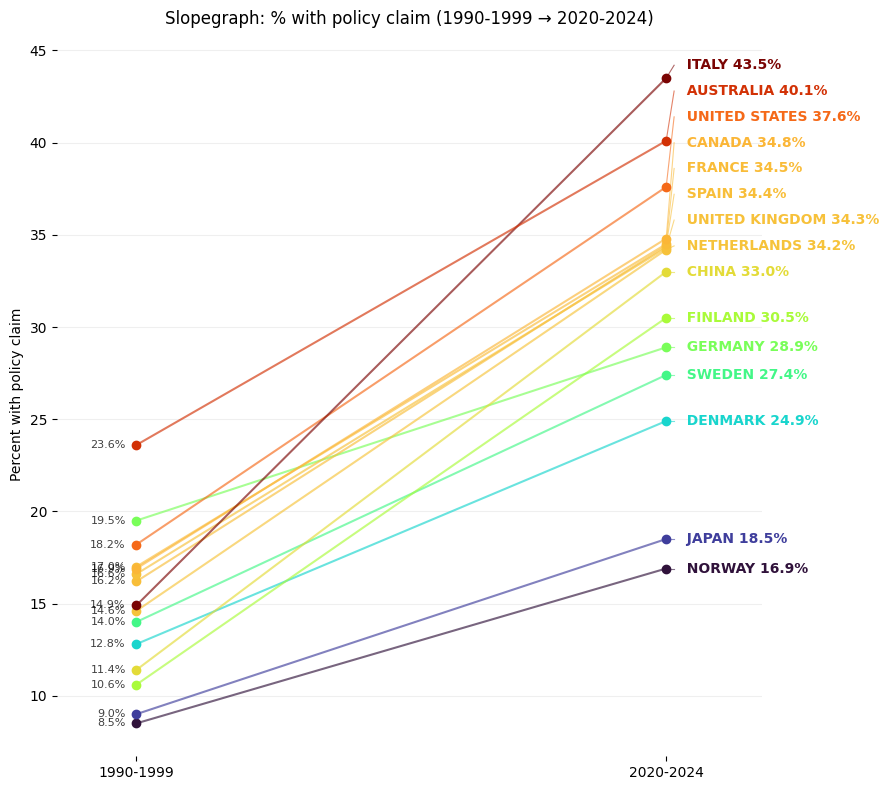

In [109]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from pathlib import Path

# --- Extract the country rows from your table1 ---
# (they start after the 'Countries' row)
country_start = row_names.index('Countries') + 1
country_rows = row_names[country_start:]

# Make a new dataframe containing just those countries and numeric values
period_country = (
    table1.loc[country_rows, [c for c in table1.columns if c in periods.keys()]]
    .applymap(lambda x: np.nan if isinstance(x, str) and not x.replace('.', '', 1).isdigit() else x)
    .astype(float)
)

# Drop any rows or columns with missing values
period_country = period_country.dropna(how="all", axis=0).dropna(how="all", axis=1)

# --- Prepare columns for slopegraph ---
start_col = '1990-1999'
end_col = '2020-2024'

if start_col not in period_country.columns:
    start_col = period_country.columns[0]
if end_col not in period_country.columns:
    end_col = period_country.columns[-1]

data = period_country[[start_col, end_col]].copy()
data = data.dropna()

# Remove 'Unknown' or blank countries
data = data[~data.index.str.lower().str.contains('unknown')]

# --- Sort to reduce line crossings ---
order_score = 0.3 * data[start_col] + 0.7 * data[end_col]
data = data.loc[order_score.sort_values().index]

# --- Assign colors based on END value ---
end_values = data[end_col].values
norm_values = (end_values - end_values.min()) / (end_values.max() - end_values.min())
colors = cm.turbo(norm_values)
country_colors = dict(zip(data.index, colors))

# --- Compute non-overlapping y label positions ---
y_end_true = data[end_col].to_numpy(dtype=float)
min_gap = 1.4  # label spacing in percentage points
idx = np.argsort(y_end_true)
y_lab = y_end_true.copy()
for i in range(1, len(idx)):
    j, k = idx[i], idx[i-1]
    if y_lab[j] - y_lab[k] < min_gap:
        y_lab[j] = y_lab[k] + min_gap

y_label_pos = dict(zip(data.index[idx], y_lab[idx]))

y_end_true = data[end_col].to_numpy(dtype=float)
min_gap_right = 1.4
idxR = np.argsort(y_end_true)
y_lab_right = y_end_true.copy()
for i in range(1, len(idxR)):
    j, k = idxR[i], idxR[i-1]
    if y_lab_right[j] - y_lab_right[k] < min_gap_right:
        y_lab_right[j] = y_lab_right[k] + min_gap_right
y_label_pos_right = dict(zip(data.index[idxR], y_lab_right[idxR]))

# --- Plot the slopegraph ---
fig_h = max(8, 0.18 * len(data))
fig, ax = plt.subplots(figsize=(9, fig_h))
x0, x1 = 0.0, 1.0

for cty, row in data.iterrows():
    y0, y1 = float(row[start_col]), float(row[end_col])
    y1_lab = float(y_label_pos[cty])
    color = country_colors[cty]

    # line and points
    ax.plot([x0, x1], [y0, y1], linewidth=1.5, alpha=0.65, color=color)
    ax.scatter([x0, x1], [y0, y1], s=36, zorder=3, color=color)

    # text labels
    ax.text(x0 - 0.02, y0, f"{y0:.1f}%", ha="right", va="center", fontsize=8, alpha=0.75)
    ax.plot([x1, x1 + 0.015], [y1, y1_lab], linewidth=0.8, alpha=0.6, color=color)
    ax.text(x1 + 0.02, y1_lab, f"{cty.upper()} {y1:.1f}%", ha="left", va="center",
            fontsize=10, fontfamily="sans-serif", fontweight="bold", color=color)

# Cosmetics
ax.set_xlim(-0.15, 1.18)
ax.set_xticks([x0, x1])
ax.set_xticklabels([start_col, end_col])
ax.set_ylabel("Percent with policy claim")
ax.set_title(f"Slopegraph: % with policy claim ({start_col} → {end_col})")
ax.grid(axis='y', alpha=0.2, linewidth=0.8)
for s in ax.spines.values():
    s.set_visible(False)

plt.tight_layout()
plt.savefig(FIGURE_DIR / "fig_slopegraph_policy_claims.png")
plt.show() 

# Fig 3 - Journals 
Here we address the core goal: plotting classification status by journal and year in both absolute cumulative and relative terms.

## 3.1. Overall Comparison: Policy Claim Rate by Journal (All Years Pooled)

Before looking at trends over time, let's establish a baseline. This bar chart shows the overall percentage of articles containing a policy claim for each of the top 15 journals, calculated across all available years.

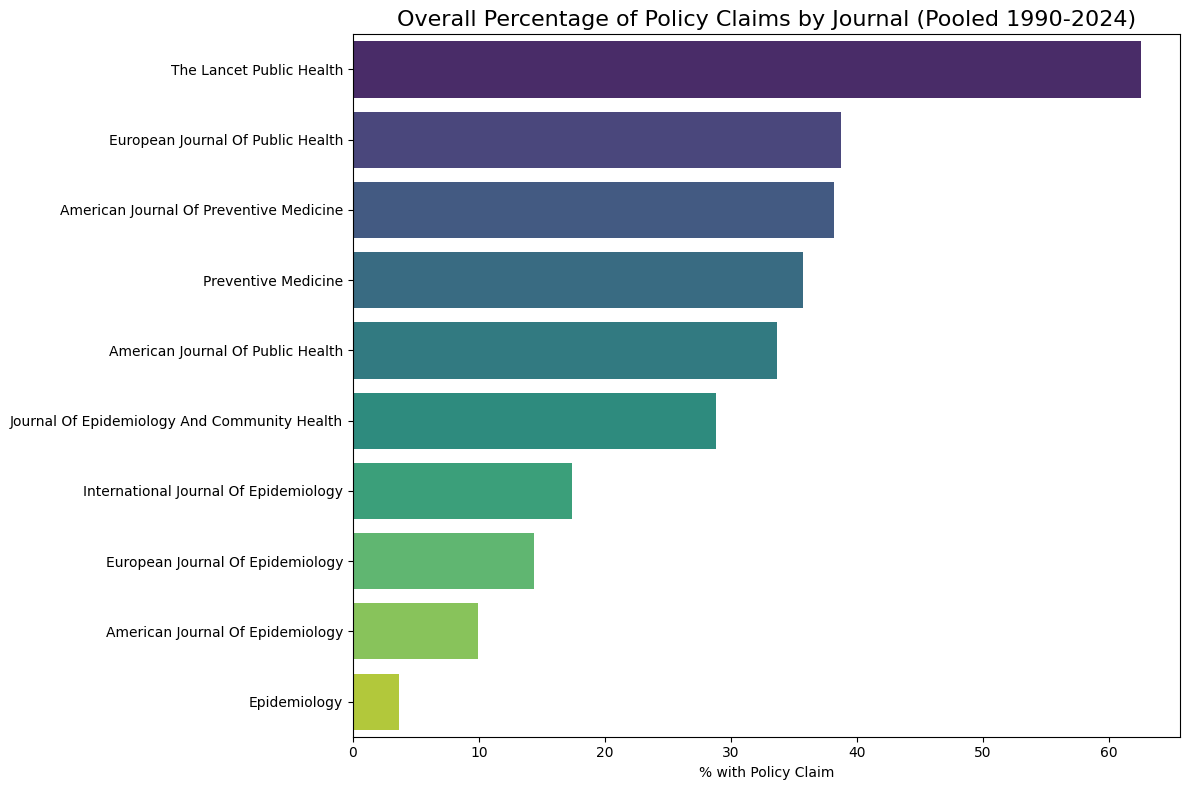

In [110]:
# Calculate the mean claim rate for each journal, pooled across all years
overall_journal_rate = df.groupby(JOURNAL_COLUMN)['claim'].mean().reset_index()

# Use all journals for the plot
plot_data = overall_journal_rate.copy()

# Sort the data for a more readable plot
plot_data = plot_data.sort_values(by='claim', ascending=False)

# Convert the fraction to a percentage for the plot
plot_data['percent_claim'] = plot_data['claim'] * 100

# Create the bar plot
plt.figure(figsize=(12, max(8, 0.4*len(plot_data)))) # Adjust height for number of journals
sns.barplot(
    data=plot_data,
    x='percent_claim',
    y=JOURNAL_COLUMN,
    palette='viridis' # Using a different color palette
)

plt.title('Overall Percentage of Policy Claims by Journal (Pooled 1990-2024)', fontsize=16)
plt.xlabel('% with Policy Claim')
plt.ylabel('') # The y-axis is self-explanatory with the journal names
plt.tight_layout()

plt.savefig(FIGURE_DIR / "overall_percent_by_journal.png")
plt.show()

## Combined plot-  by journal ... Absolute Trends

This plot shows the total count of policy claims accumulating over time for each of the top journals. This is useful for seeing which journals have produced the largest absolute number of claims. We will plot the top 15 journals to keep the visualization clean.

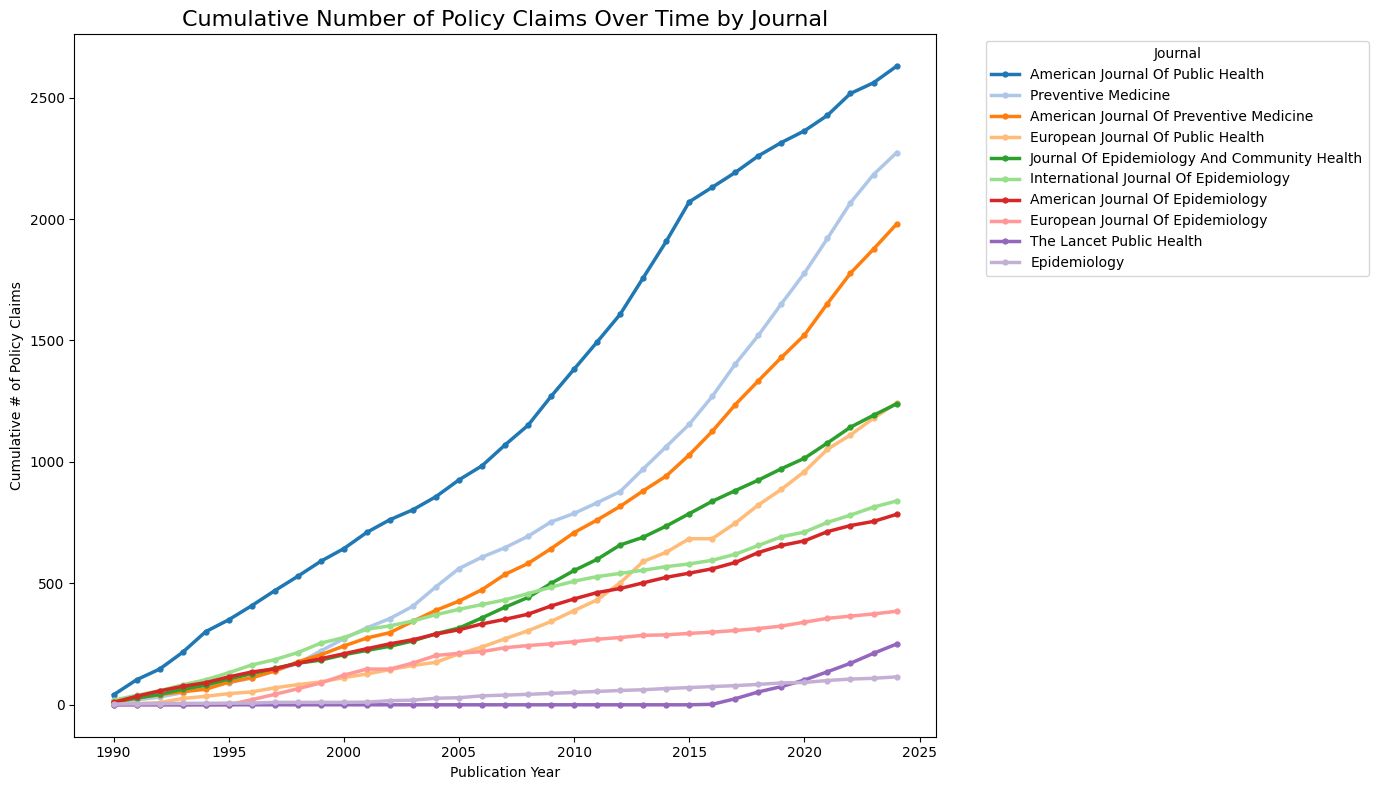

In [111]:
# Group by year and journal, count claims, and then calculate the cumulative sum for all journals
cumulative_counts = (
    df.groupby([YEAR_COLUMN, JOURNAL_COLUMN])['claim']
    .sum()
    .unstack(fill_value=0)
    .cumsum()
)

# Sort columns (journals) by their final cumulative value descending
final_order = cumulative_counts.iloc[-1].sort_values(ascending=False).index
cumulative_counts = cumulative_counts[final_order]

palette = (sns.color_palette("tab20", n_colors=len(final_order))
           if len(final_order) <= 20 else sns.color_palette("hls", n_colors=len(final_order)))
journal_colors = dict(zip(final_order, palette))

# Create the plot
plt.figure(figsize=(14, max(8, 0.4*len(final_order))))
ax = cumulative_counts.plot(
    ax=plt.gca(),
    marker='o', linestyle='-',
    linewidth=2.5,            
    markersize=3.5,             
    color=[journal_colors[j] for j in final_order]
)

plt.title('Cumulative Number of Policy Claims Over Time by Journal', fontsize=16)
plt.ylabel('Cumulative # of Policy Claims')
plt.xlabel('Publication Year')
plt.legend(title='Journal', bbox_to_anchor=(1.05, 1), loc='upper left', labels=final_order)
plt.tight_layout()

plt.savefig(FIGURE_DIR / "cumulative_absolute_by_journal.png")
plt.show() 

## 3.2. Relative Trends: Percentage (%) of Claims per Year

This plot shows the annual percentage of articles with policy claims. This view is great for spotting year-to-year variability and recent changes in a journal's focus.

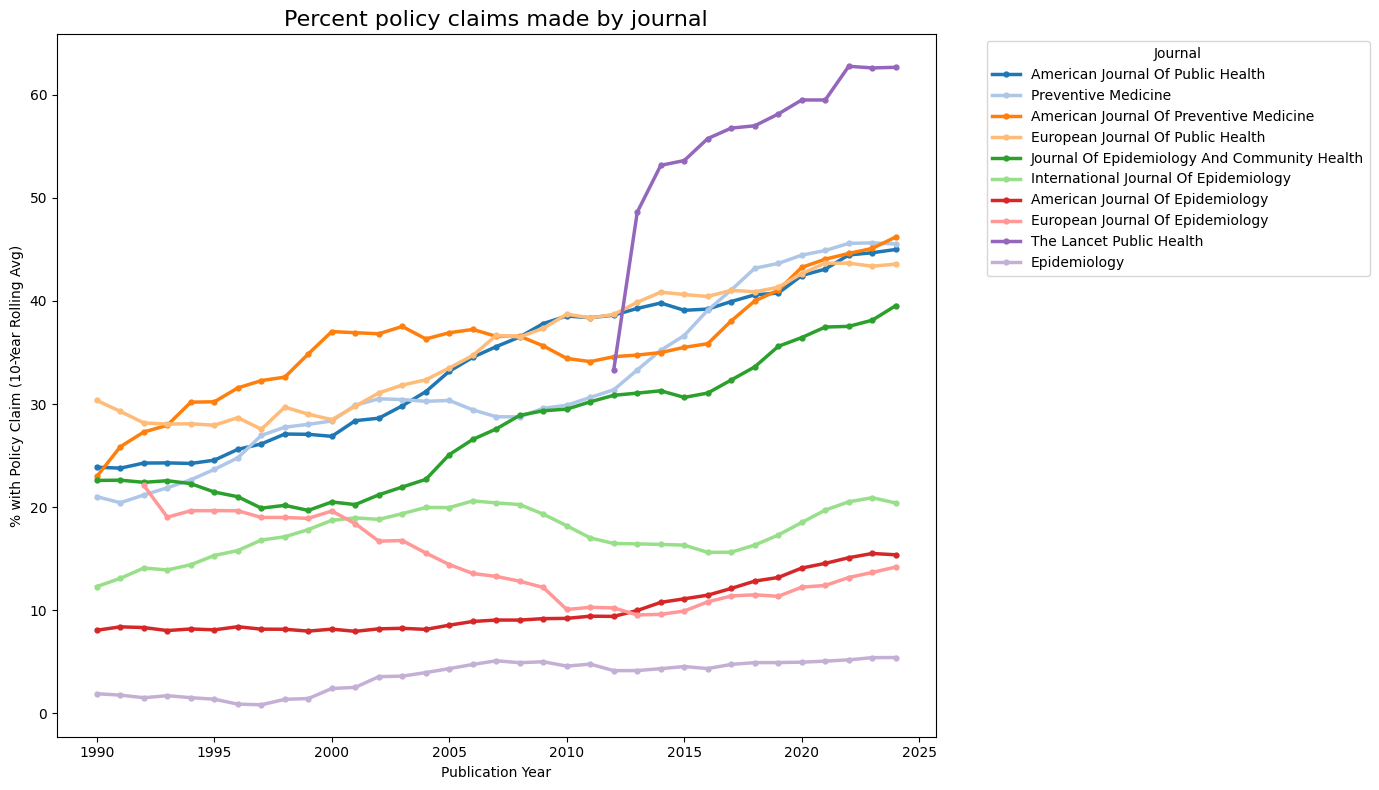

In [112]:
# Mean claim rate by journal and year (%)
yearly_percent_df = (
    df.groupby([YEAR_COLUMN, JOURNAL_COLUMN])['claim']
      .mean()
      .mul(100)
      .reset_index(name='percent_claim')
)

# 10 year centered rolling average
pivoted_df = yearly_percent_df.pivot(index=YEAR_COLUMN, columns=JOURNAL_COLUMN, values='percent_claim')

# ensure a continuous year index
year_idx = pd.RangeIndex(pivoted_df.index.min(), pivoted_df.index.max() + 1)
pivoted_df = pivoted_df.reindex(year_idx)

rolling_avg_df = pivoted_df.rolling(window=10, min_periods=1, center=True).mean()

# align columns to the same order used above
legend_order = [j for j in final_order if j in rolling_avg_df.columns]
rolling_avg_df = rolling_avg_df[legend_order]

# Plot with pandas/matplotlib to keep style consistent with the cumulative figure
plt.figure(figsize=(14, max(8, 0.4*len(legend_order))))
ax = rolling_avg_df.plot(
    ax=plt.gca(),
    marker='o', linestyle='-',
    linewidth=2.5,
    markersize=3.5,
    color=[journal_colors[j] for j in legend_order]
)

plt.title('Percent policy claims made by journal', fontsize=16)
plt.ylabel('% with Policy Claim (10-Year Rolling Avg)')
plt.xlabel('Publication Year')
plt.legend(title='Journal', bbox_to_anchor=(1.05, 1), loc='upper left', labels=legend_order)
plt.tight_layout()

plt.savefig(FIGURE_DIR / "yearly_percent_by_journal_smoothed.png")
plt.show()

# Fig 4 - study design (from keywords)

Applying classification methods...
Classification complete.

SUMMARY TABLES

--- Main Results: Combined Method (Strict with Keyword Fallback) ---
Total articles classified: 8715 / 45807
Excluded 37092 articles (81.0%)
      study_design_group  policy_claim_pct  n_articles
            Experimental         10.843373         166
      Quasi-experimental         25.181951         687
                  Cohort         18.004459        3588
         Cross-sectional         38.433293        1634
Ecological / Time-series         23.417722         158
            Case-control          9.878610        2389
             Qualitative         48.387097          93


--- Sensitivity Analysis: Strict (Title/Abstract) vs. Keywords ---
Strict method classified 6165 articles. Keyword method classified 3742 articles.
      study_design_group Strict (Title/Abstract)       Keywords
            Experimental             7.8% (n=64)  12.3% (n=106)
      Quasi-experimental           25.5% (n=502)  21.3% (n=263)


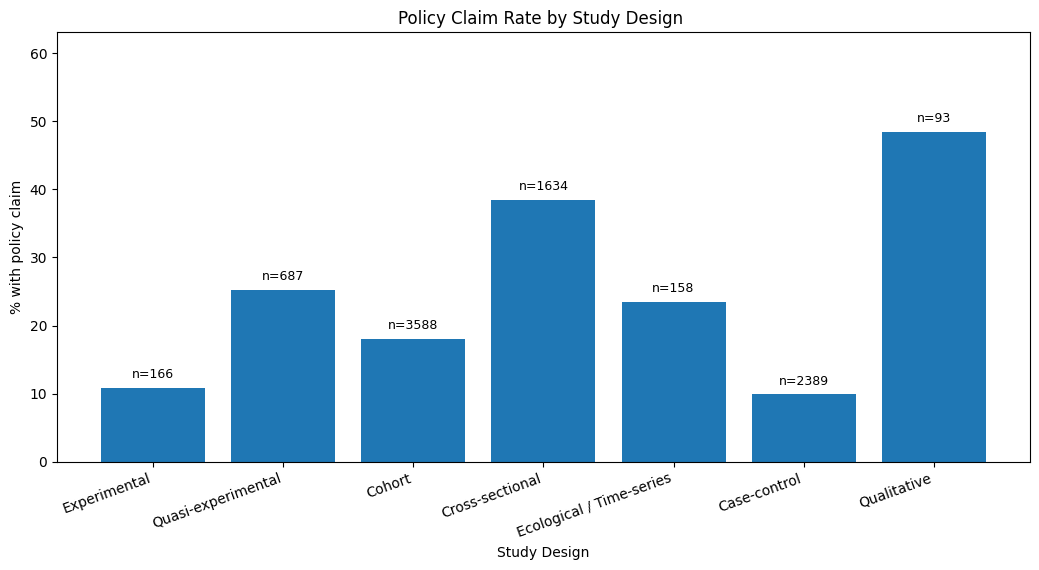

In [113]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. SETUP AND DATA PREPARATION (Done Once) ---
# Assume 'df' is your pre-loaded DataFrame.
if 'llm_policy_claim' not in df.columns or 'keywords' not in df.columns or 'title' not in df.columns or 'abstract' not in df.columns:
    raise KeyError("Ensure df contains 'llm_policy_claim', 'keywords', 'title', and 'abstract' columns.")

df = df.copy()
df = df[df['llm_policy_claim'].notna()]
df['llm_policy_claim'] = df['llm_policy_claim'].astype(bool)

# --- 2. DEFINE PATTERNS & HELPER FUNCTIONS ---

# Helper to normalize patterns (e.g., spelling, hyphens)
def normalize_patterns(patterns):
    out = []
    for p in patterns:
        p = p.replace('randomised', 'randomi').replace('randomized', 'randomi')
        p = p.replace('time-series', 'time series').replace('meta-analysis', 'meta analysis')
        out.append(p)
    return out

# --- Method 1: Strict Phrase Patterns (for Title/Abstract) ---
strict_design_patterns = {
    'Experimental': ['a randomi... controlled trial', 'a randomi... trial', 'randomi... clinical trial', 'double-blind', 'placebo-controlled trial'],
    'Quasi-experimental': ['a quasi-experimental', 'quasi-experimental study', 'natural experiment', 'difference-in-differences', 'interrupted time series', 'regression discontin...'],
    'Cohort': ['a cohort study', 'a prospective cohort', 'a retrospective cohort', 'a longitudinal study', 'a longitudinal analysis'],
    'Case-control': ['a case-control study', 'case-control study', 'matched case-control'],
    'Cross-sectional': ['a cross-sectional study', 'cross-sectional study',  'cross-sectional survey'],
    'Qualitative': ['a qualitative study', 'qualitative analysis', 'qualitative approach'],
    'Ecological / Time-series': ['an ecological study', 'ecological design', 'time series analysis'],
}
strict_design_patterns = {k: normalize_patterns(v) for k, v in strict_design_patterns.items()}

# --- Method 2: Broader Keyword Patterns (for Keywords column) ---
keyword_design_patterns = {
    'Experimental': ['randomi... controlled trial', 'randomi... trial', 'clinical trial', 'RCT', 'pragmatic trial', 'cluster randomi', 'stepped wedge'],
    'Quasi-experimental': ['quasi-experimental', 'natural experiment', 'difference in difference', 'did design', 'event study', 'regression discontinuity', 'interrupted time series', 'its', 'synthetic control'],
    'Cohort': ['cohort study', 'cohort studies', 'prospective cohort', 'retrospective cohort', 'longitudinal study', 'longitudinal', 'longitudinal cohort', 'follow-up study', 'panel study'],
    'Case-control': ['case-control', 'matched case-control', 'nested case-control'],
    'Cross-sectional': ['cross-sectional', 'prevalence study', 'baseline survey'],
    'Ecological / Time-series': ['ecological study', 'time series', 'ts analysis'],
    'Qualitative': ['qualitative', 'focus group', 'thematic analysis', 'ethnograph'],
}
keyword_design_patterns = {k: normalize_patterns(v) for k, v in keyword_design_patterns.items()}

# --- 3. CLASSIFICATION LOGIC ---

# *** NEW: Define a clear hierarchy for checking designs ***
# This ensures that more specific designs are matched before broader ones.
DESIGN_HIERARCHY = [
    'Experimental',
    'Quasi-experimental', # Crucially, this is checked BEFORE Cohort
    'Cohort',
    'Case-control',
    'Cross-sectional',
    'Ecological / Time-series',
    'Qualitative',
    # Note: Systematic Review is not in the strict patterns, so it won't be checked there.
]


# Keyword parser
def parse_keywords(val):
    if isinstance(val, str): toks = re.findall(r"'([^']+)'", val)
    elif isinstance(val, (list, tuple)): toks = [str(t) for t in val if pd.notna(t)]
    else: toks = []
    return [t.strip().lower() for t in toks if t.strip()]

# Method 1: Strict classification function (Title/Abstract)
def assign_design_strict(row):
    title = str(row.get('title', '')).lower()
    abstract = str(row.get('abstract', '')).lower()
    text_to_search = title + " " + abstract
    
    # *** MODIFIED: Loop through the explicit hierarchy ***
    for group in DESIGN_HIERARCHY:
        patterns = strict_design_patterns.get(group, [])
        if any(pat in text_to_search for pat in patterns):
            return group
    return 'Other/None'

# Method 2: Keyword classification function
def assign_design_keywords(row):
    keywords = parse_keywords(row.get('keywords', ''))
    if not keywords: return 'Other/None'
    
    # *** MODIFIED: Loop through the explicit hierarchy ***
    for group in DESIGN_HIERARCHY:
        patterns = keyword_design_patterns.get(group, [])
        if any(pat in tok for tok in keywords for pat in patterns):
            return group
    return 'Other/None'

# --- 4. APPLY CLASSIFICATIONS & COMBINE ---
print("Applying classification methods...")
df['design_strict'] = df.apply(assign_design_strict, axis=1)
df['design_keywords'] = df.apply(assign_design_keywords, axis=1)

# Combined Method: Prioritize strict, fallback to keywords
df['design_combined'] = np.where(
    df['design_strict'] != 'Other/None',
    df['design_strict'],
    df['design_keywords']
)
print("Classification complete.")

# --- 5. REUSABLE SUMMARIZATION FUNCTION ---
def summarize_and_prepare(df_in, design_col_name):
    df_filtered = df_in[df_in[design_col_name] != 'Other/None'].copy()
    summary = (
        df_filtered.groupby(design_col_name)['llm_policy_claim']
        .agg(policy_claim_pct=lambda s: 100 * s.mean(), n_articles='size')
        .reset_index()
    )
    # Updated order: Case-control after Ecological / Time-series
    order = ['Experimental', 'Quasi-experimental', 'Cohort', 'Cross-sectional', 'Ecological / Time-series', 'Case-control', 'Qualitative']
    summary[design_col_name] = pd.Categorical(summary[design_col_name], categories=order, ordered=True)
    summary = summary.sort_values(design_col_name).rename(columns={design_col_name: 'study_design_group'})
    excluded_count = len(df_in) - len(df_filtered)
    return summary, excluded_count

# --- 6. GENERATE SUMMARIES FOR ALL METHODS ---
summary_strict, excluded_strict = summarize_and_prepare(df, 'design_strict')
summary_keywords, excluded_keywords = summarize_and_prepare(df, 'design_keywords')
summary_combined, excluded_combined = summarize_and_prepare(df, 'design_combined')

# --- 7. PLOT THE COMBINED RESULT ---
plt.figure(figsize=(10.5, 5.8))
x = np.arange(len(summary_combined))
y = summary_combined['policy_claim_pct'].values
labels = summary_combined['study_design_group'].astype(str).tolist()

plt.bar(x, y)
plt.xticks(x, labels, rotation=20, ha='right')
plt.ylabel('% with policy claim')
plt.xlabel('Study Design')
plt.title('Policy Claim Rate by Study Design ')
plt.grid(False)

# Annotate counts
for xi, yi, n in zip(x, y, summary_combined['n_articles'].values):
    pad = max(1, 0.02 * (max(y) if len(y) and max(y) > 0 else 50))
    plt.text(xi, yi + pad, f"n={int(n)}", ha='center', va='bottom', fontsize=9)

plt.ylim(0, (max(y) if len(y) else 0) * 1.20 + 5)
plt.tight_layout()

# --- 8. PRINT TABULATED RESULTS ---
print("\n" + "="*80)
print("SUMMARY TABLES")
print("="*80)

# Table 1: Main results from the combined method (matches the plot)
print("\n--- Main Results: Combined Method (Strict with Keyword Fallback) ---")
print(f"Total articles classified: {summary_combined['n_articles'].sum()} / {len(df)}")
print(f"Excluded {excluded_combined} articles ({excluded_combined/len(df)*100:.1f}%)")
print(summary_combined.to_string(index=False))

# Table 2: Sensitivity analysis comparing the two methods
print("\n\n--- Sensitivity Analysis: Strict (Title/Abstract) vs. Keywords ---")
# Merge the two summaries to create the comparison table
comparison_table = pd.merge(summary_strict, summary_keywords, on='study_design_group', how='outer', suffixes=('_strict', '_keywords'))
# Fill NaNs with 0 before formatting
numeric_cols = comparison_table.columns.drop('study_design_group')
comparison_table[numeric_cols] = comparison_table[numeric_cols].fillna(0)

# Format the columns to combine percentage and count
comparison_table['Strict (Title/Abstract)'] = comparison_table.apply(
    lambda row: f"{row['policy_claim_pct_strict']:.1f}% (n={int(row['n_articles_strict'])})", axis=1
)
comparison_table['Keywords'] = comparison_table.apply(
    lambda row: f"{row['policy_claim_pct_keywords']:.1f}% (n={int(row['n_articles_keywords'])})", axis=1
)

# Select and display the final formatted table
final_table = comparison_table[['study_design_group', 'Strict (Title/Abstract)', 'Keywords']]
print(f"Strict method classified {len(df) - excluded_strict} articles. Keyword method classified {len(df) - excluded_keywords} articles.")
print(final_table.to_string(index=False))

print(f"\n=== EXAMPLES OF abstract/title PATTERNS ===")
print("✅ WILL MATCH:")
print("  - 'We conducted a cross-sectional study of...'")
print("  - 'This longitudinal analysis followed patients...'") 
print("  - 'A randomized controlled trial was performed...'")
print("  - 'Participants were interviewed using...'")

print("\n❌ WILL NOT MATCH:")
print("  - 'Cross-sectional area of the vessel...' (not about study design)")
print("  - 'Longitudinal muscle fibers...' (anatomical, not methodological)")
print("  - 'Interview with the patient revealed...' (clinical interview, not research method)")
print("  - 'Survey the literature...' (not a survey study)")


plt.savefig(FIGURE_DIR / "policy_claim_rate_by_study_design.png")
plt.show() 

In [114]:
print(df.columns.tolist())

['scopus_id', 'doi', 'title', 'journal', 'publication_year', 'keywords', 'abstract', 'article_type', 'corresponding_author_country', 'cited_by_count', 'llm_policy_claim', 'claim', 'design_strict', 'design_keywords', 'design_combined']


## lower parts of Fig ... study design with loess

Dataset spans 1990-2024
Total articles: 45807
Applying classification methods...

TEMPORAL ANALYSIS RESULTS

📊 DATASET OVERVIEW
Time span: 1990-2024
Total articles analyzed: 8715
Average articles per year: 249.0

📈 TREND ANALYSIS
Statistical significance of trends (linear regression):
  Experimental        : Stable     (R²=0.041, p=0.254) 
  Quasi-experimental  : Increasing (R²=0.806, p=0.000) ***
  Cohort              : Increasing (R²=0.846, p=0.000) ***
  Case-control        : Decreasing (R²=0.874, p=0.000) ***
  Cross-sectional     : Increasing (R²=0.443, p=0.000) ***
  Ecological / Time-series: Stable     (R²=0.018, p=0.440) 
  Qualitative         : Stable     (R²=0.094, p=0.112) 

📋 SUMMARY BY TIME PERIODS
             total_articles  avg_policy_claim_rate most_common_design
time_period                                                          
1990-1994               819                   10.9       Case-control
1995-1999              1204                   13.5       Case-control

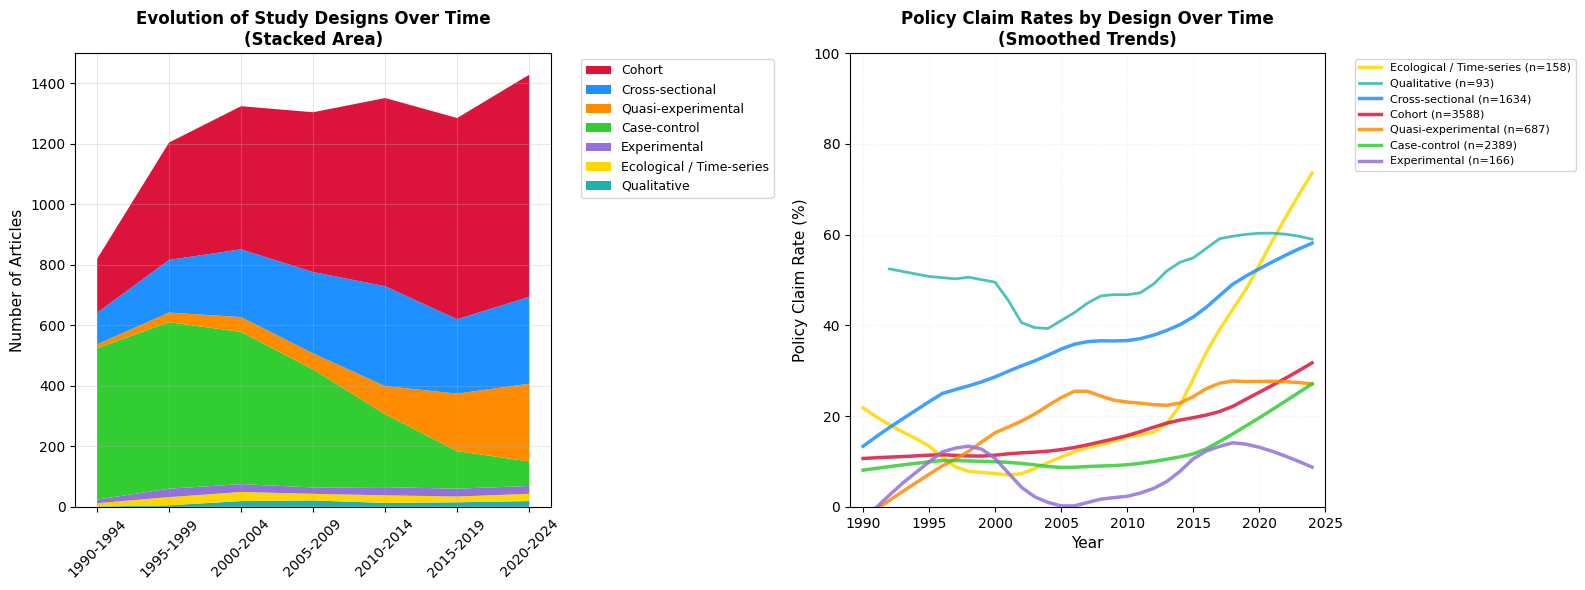

In [115]:
import re
import seaborn as sns
from scipy import stats
import warnings
from statsmodels.nonparametric.smoothers_lowess import lowess
warnings.filterwarnings('ignore')

# --- 1. SETUP AND DATA PREPARATION ---
# Assume 'df' is your pre-loaded DataFrame with 'publication_year' column
required_cols = ['llm_policy_claim', 'keywords', 'title', 'abstract', 'publication_year']
if not all(col in df.columns for col in required_cols):
    raise KeyError(f"Ensure df contains these columns: {required_cols}")

df = df.copy()
df = df[df['llm_policy_claim'].notna()]
df['llm_policy_claim'] = df['llm_policy_claim'].astype(bool)

# Filter for valid publication years (1990-2024)
df = df[(df['publication_year'] >= 1990) & (df['publication_year'] <= 2024)]
print(f"Dataset spans {df['publication_year'].min()}-{df['publication_year'].max()}")
print(f"Total articles: {len(df)}")

# --- 2. DEFINE PATTERNS & HELPER FUNCTIONS (Same as original) ---
def normalize_patterns(patterns):
    out = []
    for p in patterns:
        p = p.replace('randomised', 'randomi').replace('randomized', 'randomi')
        p = p.replace('time-series', 'time series').replace('meta-analysis', 'meta analysis')
        out.append(p)
    return out

# Strict patterns for Title/Abstract
strict_design_patterns = {
    'Experimental': ['a randomi... controlled trial', 'a randomi... trial', 'randomi... clinical trial', 'double-blind', 'placebo-controlled trial'],
    'Quasi-experimental': ['a quasi-experimental', 'quasi-experimental study', 'natural experiment', 'difference-in-differences', 'interrupted time series', 'regression discontin...'],
    'Cohort': ['a cohort study', 'a prospective cohort', 'a retrospective cohort', 'a longitudinal study', 'a longitudinal analysis'],
    'Case-control': ['a case-control study', 'case-control study', 'matched case-control'],
    'Cross-sectional': ['a cross-sectional study', 'cross-sectional study',  'cross-sectional survey'],
    'Qualitative': ['a qualitative study', 'qualitative analysis', 'qualitative approach'],
    'Ecological / Time-series': ['an ecological study', 'ecological design', 'time series analysis'],
}
strict_design_patterns = {k: normalize_patterns(v) for k, v in strict_design_patterns.items()}

# Keyword patterns
keyword_design_patterns = {
    'Experimental': ['randomi... controlled trial', 'randomi... trial', 'clinical trial', 'RCT', 'pragmatic trial', 'cluster randomi', 'stepped wedge'],
    'Quasi-experimental': ['quasi-experimental', 'natural experiment', 'difference in difference', 'did design', 'event study', 'regression discontinuity', 'interrupted time series', 'its', 'synthetic control'],
    'Cohort': ['cohort study', 'cohort studies', 'prospective cohort', 'retrospective cohort', 'longitudinal study', 'longitudinal', 'longitudinal cohort', 'follow-up study', 'panel study'],
    'Case-control': ['case-control', 'matched case-control', 'nested case-control'],
    'Cross-sectional': ['cross-sectional', 'prevalence study', 'baseline survey'],
    'Ecological / Time-series': ['ecological study', 'time series', 'ts analysis'],
    'Qualitative': ['qualitative', 'focus group', 'thematic analysis', 'ethnograph'],
}
keyword_design_patterns = {k: normalize_patterns(v) for k, v in keyword_design_patterns.items()}

DESIGN_HIERARCHY = [
    'Experimental', 'Quasi-experimental', 'Cohort', 'Case-control',
    'Cross-sectional', 'Ecological / Time-series', 'Qualitative'
]

def parse_keywords(val):
    if isinstance(val, str): toks = re.findall(r"'([^']+)'", val)
    elif isinstance(val, (list, tuple)): toks = [str(t) for t in val if pd.notna(t)]
    else: toks = []
    return [t.strip().lower() for t in toks if t.strip()]

def assign_design_strict(row):
    title = str(row.get('title', '')).lower()
    abstract = str(row.get('abstract', '')).lower()
    text_to_search = title + " " + abstract
    
    for group in DESIGN_HIERARCHY:
        patterns = strict_design_patterns.get(group, [])
        if any(pat in text_to_search for pat in patterns):
            return group
    return 'Other/None'

def assign_design_keywords(row):
    keywords = parse_keywords(row.get('keywords', ''))
    if not keywords: return 'Other/None'
    
    for group in DESIGN_HIERARCHY:
        patterns = keyword_design_patterns.get(group, [])
        if any(pat in tok for tok in keywords for pat in patterns):
            return group
    return 'Other/None'

# --- 3. APPLY CLASSIFICATIONS ---
print("Applying classification methods...")
df['design_strict'] = df.apply(assign_design_strict, axis=1)
df['design_keywords'] = df.apply(assign_design_keywords, axis=1)
df['design_combined'] = np.where(
    df['design_strict'] != 'Other/None',
    df['design_strict'],
    df['design_keywords']
)

# --- 4. TEMPORAL ANALYSIS FUNCTIONS ---
def create_time_periods(df, period_size=5):
    """Create time periods for analysis"""
    min_year, max_year = df['publication_year'].min(), df['publication_year'].max()
    periods = []
    for start in range(min_year, max_year + 1, period_size):
        end = min(start + period_size - 1, max_year)
        periods.append(f"{start}-{end}")
        df.loc[(df['publication_year'] >= start) & (df['publication_year'] <= end), 'time_period'] = f"{start}-{end}"
    return df, periods

def calculate_trends(df_filtered, design_col):
    """Calculate trend statistics for each design type"""
    trends = {}
    
    for design in DESIGN_HIERARCHY:
        design_data = df_filtered[df_filtered[design_col] == design]
        if len(design_data) < 10:  # Skip if too few observations
            continue
            
        # Calculate correlation between year and count
        yearly_counts = design_data.groupby('publication_year').size()
        years = yearly_counts.index.values
        counts = yearly_counts.values
        
        if len(years) > 3:
            slope, intercept, r_value, p_value, std_err = stats.linregress(years, counts)
            trends[design] = {
                'slope': slope,
                'r_squared': r_value**2,
                'p_value': p_value,
                'trend': 'Increasing' if slope > 0 and p_value < 0.05 else 
                        'Decreasing' if slope < 0 and p_value < 0.05 else 'Stable'
            }
    
    return trends

# --- 5. CREATE TIME PERIODS AND TEMPORAL SUMMARIES ---
df_filtered = df[df['design_combined'] != 'Other/None'].copy()
df_with_periods, periods = create_time_periods(df_filtered, period_size=5)

# Summary by time periods
temporal_summary = (
    df_with_periods.groupby(['time_period', 'design_combined'])
    .agg(
        n_articles=('design_combined', 'size'),
        policy_claim_pct=('llm_policy_claim', lambda x: 100 * x.mean())
    ).reset_index()
)

# Pivot for easier plotting
temporal_pivot = temporal_summary.pivot(
    index='time_period', 
    columns='design_combined', 
    values='n_articles'
).fillna(0)

policy_pivot = temporal_summary.pivot(
    index='time_period', 
    columns='design_combined', 
    values='policy_claim_pct'
).fillna(0)

# --- 6. CALCULATE TREND STATISTICS ---
trends = calculate_trends(df_filtered, 'design_combined')

# --- 7. CREATE FOCUSED PLOTS WITH ENHANCED COLORS ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Define bold, saturated colors for better visibility
bold_colors = [
    '#E74C3C',  # Bright Red
    '#3498DB',  # Bright Blue
    '#2ECC71',  # Bright Green
    '#F39C12',  # Bright Orange
    '#9B59B6',  # Bright Purple
    '#1ABC9C',  # Bright Teal
    '#E67E22',  # Bright Dark Orange
    '#34495E',  # Dark Blue-Gray
    '#16A085',  # Dark Teal
    '#8E44AD',  # Dark Purple
]

# Create a FIXED color mapping with specific color assignments
fixed_color_map = {
    'Cohort': '#DC143C',  # Crimson Red (vibrant red)
    'Cross-sectional': '#1E90FF',  # Dodger Blue (vibrant blue)
    'Quasi-experimental': '#FF8C00',  # Dark Orange (vibrant orange)
    'Case-control': '#32CD32',  # Lime Green (vibrant green)
    'Experimental': '#9370DB',  # Medium Purple (vibrant purple)
    'Ecological / Time-series': '#FFD700',  # Gold (vibrant yellow)
    'Qualitative': '#20B2AA',  # Light Sea Green (vibrant teal)
}

# Ensure all designs have a color (fallback for any missing)
for design in DESIGN_HIERARCHY:
    if design not in fixed_color_map:
        fixed_color_map[design] = bold_colors[len(fixed_color_map) % len(bold_colors)]

# Plot 1: Stacked area chart of study design evolution
# Order columns by their PERCENTAGE in the most recent period (highest % at top of stack)
available_cols = [col for col in DESIGN_HIERARCHY if col in temporal_pivot.columns]
most_recent_period = temporal_pivot.index[-1]
recent_values_counts = temporal_pivot.loc[most_recent_period, available_cols].fillna(0)

# Calculate percentages for the most recent period
total_recent = recent_values_counts.sum()
recent_percentages = (recent_values_counts / total_recent * 100) if total_recent > 0 else recent_values_counts

# Order by percentage (ascending so highest % appears at top of stack when stacked)
ordered_cols_stack = recent_percentages.sort_values(ascending=True).index.tolist()
temporal_pivot_ordered = temporal_pivot[ordered_cols_stack]

# For legend display, we want highest % first (reverse the stack order)
ordered_cols_legend = ordered_cols_stack[::-1]

# Stack plot using FIXED color mapping with full opacity for vibrancy
ax1.stackplot(range(len(temporal_pivot_ordered)), 
              *[temporal_pivot_ordered[col].values for col in ordered_cols_stack],
              labels=ordered_cols_stack, alpha=1.0,  # Full opacity for more vibrant colors
              colors=[fixed_color_map[col] for col in ordered_cols_stack])
ax1.set_xticks(range(len(temporal_pivot_ordered)))
ax1.set_xticklabels(temporal_pivot_ordered.index, rotation=45)
ax1.set_ylabel('Number of Articles', fontsize=11)
ax1.set_title('Evolution of Study Designs Over Time\n(Stacked Area)', fontsize=12, fontweight='bold')

# Custom legend with correct order (highest % at top)
handles, labels = ax1.get_legend_handles_labels()
# Create a mapping of labels to handles
label_to_handle = dict(zip(labels, handles))
# Reorder handles to match our desired legend order
ordered_handles = [label_to_handle[label] for label in ordered_cols_legend]
ax1.legend(ordered_handles, ordered_cols_legend, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Policy claim rates over time WITH LOESS SMOOTHING
# For the right plot, use YEARLY data instead of period data for smoother curves

# First, get the count of articles per design per year to assess data density
yearly_counts = (
    df_filtered.groupby(['publication_year', 'design_combined'])
    .size()
    .reset_index(name='n_articles')
)

yearly_policy_rates = (
    df_filtered.groupby(['publication_year', 'design_combined'])
    ['llm_policy_claim'].mean() * 100
).reset_index()

# Merge to get both rates and counts
yearly_data_full = yearly_policy_rates.merge(
    yearly_counts, 
    on=['publication_year', 'design_combined']
)

# Pivot to get years as index and designs as columns
yearly_policy_pivot = yearly_policy_rates.pivot(
    index='publication_year',
    columns='design_combined',
    values='llm_policy_claim'
)

yearly_counts_pivot = yearly_counts.pivot(
    index='publication_year',
    columns='design_combined',
    values='n_articles'
).fillna(0)

# Get the most recent year's data for ordering
most_recent_year = yearly_policy_pivot.index[-1]
# Get values for the most recent year, handling NaN
recent_year_values = {}
for design in available_cols:
    if design in yearly_policy_pivot.columns:
        # Look for most recent non-NaN value
        design_data = yearly_policy_pivot[design].dropna()
        if len(design_data) > 0:
            # Get the value from the most recent year with data
            recent_year_values[design] = design_data.iloc[-1]
        else:
            recent_year_values[design] = 0
    else:
        recent_year_values[design] = 0

# Sort by most recent values (descending)
ordered_cols_right = sorted(recent_year_values.keys(), 
                            key=lambda x: recent_year_values[x], 
                            reverse=True)

# Create a cleaner plot with ONLY smooth lines
for design in ordered_cols_right:
    if design in yearly_policy_pivot.columns:
        # Get yearly data
        yearly_data = yearly_policy_pivot[design].dropna()
        yearly_counts_design = yearly_counts_pivot[design][yearly_data.index]
        
        if len(yearly_data) >= 3:  # Need at least 3 points
            years = yearly_data.index.values
            rates = yearly_data.values
            counts = yearly_counts_design.values
            
            # Calculate total articles for this design
            total_articles = yearly_counts_design.sum()
            
            # Decision logic for visualization - NO SCATTER POINTS
            if total_articles >= 100 and len(yearly_data) >= 10:
                # Well-sampled data: LOESS smoothing
                frac_value = max(0.25, min(0.4, 15/len(yearly_data)))
                
                try:
                    smoothed = lowess(rates, years, frac=frac_value, return_sorted=True)
                    ax2.plot(smoothed[:, 0], smoothed[:, 1], 
                            color=fixed_color_map[design], 
                            linewidth=2.5, 
                            label=f"{design} (n={int(total_articles)})", 
                            alpha=0.85)
                except:
                    # Fallback
                    ax2.plot(years, rates, 
                            color=fixed_color_map[design], 
                            linewidth=2, 
                            label=f"{design} (n={int(total_articles)})", 
                            alpha=0.8)
                            
            elif total_articles >= 50:
                # Moderate data: LOESS smoothing without points
                if len(yearly_data) >= 8:
                    frac_value = max(0.3, min(0.5, 15/len(yearly_data)))
                    try:
                        smoothed = lowess(rates, years, frac=frac_value, return_sorted=True)
                        ax2.plot(smoothed[:, 0], smoothed[:, 1], 
                                color=fixed_color_map[design], 
                                linewidth=2, 
                                label=f"{design} (n={int(total_articles)})", 
                                alpha=0.8)
                    except:
                        ax2.plot(years, rates, 
                                color=fixed_color_map[design], 
                                linewidth=1.8, 
                                label=f"{design} (n={int(total_articles)})", 
                                alpha=0.75)
                else:
                    # Just connect the points with a line
                    ax2.plot(years, rates, 
                            color=fixed_color_map[design], 
                            linewidth=1.5, 
                            label=f"{design} (n={int(total_articles)})", 
                            alpha=0.7)
            else:
                # Sparse data: connect with dashed line
                ax2.plot(years, rates, 
                        color=fixed_color_map[design], 
                        linewidth=1.2, 
                        label=f"{design} (n={int(total_articles)})", 
                        alpha=0.6,
                        linestyle='--')

# Customize appearance
year_range = yearly_policy_pivot.index
ax2.set_xlim(year_range.min() - 1, year_range.max() + 1)
ax2.set_xlabel('Year', fontsize=11)
ax2.set_ylabel('Policy Claim Rate (%)', fontsize=11)
ax2.set_title('Policy Claim Rates by Design Over Time\n(Smoothed Trends)', fontsize=12, fontweight='bold')

# Legend is already in correct order (by recent value)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax2.grid(True, alpha=0.2, linestyle=':')
ax2.set_ylim(0, 100)

# Set white background (no shading)
ax2.set_facecolor('white')
fig.patch.set_facecolor('white')

plt.tight_layout()

# --- 8. PRINT DETAILED RESULTS ---
print("\n" + "="*80)
print("TEMPORAL ANALYSIS RESULTS")
print("="*80)

print(f"\n📊 DATASET OVERVIEW")
print(f"Time span: {df['publication_year'].min()}-{df['publication_year'].max()}")
print(f"Total articles analyzed: {len(df_filtered)}")
print(f"Average articles per year: {len(df_filtered) / (df['publication_year'].max() - df['publication_year'].min() + 1):.1f}")

print(f"\n📈 TREND ANALYSIS")
print("Statistical significance of trends (linear regression):")
for design, trend_data in trends.items():
    significance = "***" if trend_data['p_value'] < 0.001 else "**" if trend_data['p_value'] < 0.01 else "*" if trend_data['p_value'] < 0.05 else ""
    print(f"  {design:20s}: {trend_data['trend']:10s} (R²={trend_data['r_squared']:.3f}, p={trend_data['p_value']:.3f}) {significance}")

print(f"\n📋 SUMMARY BY TIME PERIODS")
period_summary = df_with_periods.groupby('time_period').agg(
    total_articles=('design_combined', 'size'),
    avg_policy_claim_rate=('llm_policy_claim', lambda x: 100 * x.mean()),
    most_common_design=('design_combined', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'None')
).round(1)
print(period_summary.to_string())

print(f"\n🔍 KEY INSIGHTS")
# Calculate some interesting statistics
early_period = df_filtered[df_filtered['publication_year'] <= 2000]
recent_period = df_filtered[df_filtered['publication_year'] >= 2015]

print(f"• Early period (≤2000): {len(early_period)} articles")
print(f"• Recent period (≥2015): {len(recent_period)} articles")
print(f"• Growth factor: {len(recent_period) / max(len(early_period), 1):.1f}x")

if len(early_period) > 0 and len(recent_period) > 0:
    early_exp = (early_period['design_combined'] == 'Experimental').mean() * 100
    recent_exp = (recent_period['design_combined'] == 'Experimental').mean() * 100
    print(f"• Experimental studies: {early_exp:.1f}% (early) → {recent_exp:.1f}% (recent)")
    
    early_qual = (early_period['design_combined'] == 'Qualitative').mean() * 100
    recent_qual = (recent_period['design_combined'] == 'Qualitative').mean() * 100
    print(f"• Qualitative studies: {early_qual:.1f}% (early) → {recent_qual:.1f}% (recent)")

# Print legend ordering information
print(f"\n📊 LEGEND ORDERING (2020-2024 period)")
print(f"Left Panel (Stacked by Percentage - highest % at top):")
for i, design in enumerate(ordered_cols_legend, 1):
    count = temporal_pivot_ordered.loc[most_recent_period, design] if most_recent_period in temporal_pivot_ordered.index else 0
    pct = recent_percentages[design] if design in recent_percentages.index else 0
    print(f"  {i}. {design}: {count:.0f} articles ({pct:.1f}%)")

print(f"\nRight Panel (Policy Claim Rates):")
for i, design in enumerate(ordered_cols_right, 1):
    rate = policy_pivot.loc[most_recent_period, design] if most_recent_period in policy_pivot.index and design in policy_pivot.columns else 0
    print(f"  {i}. {design}: {rate:.1f}%")

print(f"\n📊 DETAILED COUNTS BY PERIOD")
print(temporal_pivot_ordered.to_string())

print(f"\n📋 POLICY CLAIM RATES BY PERIOD (%)")
policy_pivot_rounded = policy_pivot.round(1)
print(policy_pivot_rounded.to_string())

# Create summary tables in a more readable format
print(f"\n" + "="*80)
print("SUMMARY TABLES")
print("="*80)

print(f"\nTable 1: Article Counts by Study Design and Time Period")
print("-" * 60)
counts_table = temporal_pivot_ordered.copy()
counts_table['Total'] = counts_table.sum(axis=1)
totals_row = counts_table.sum(axis=0)
totals_row.name = 'Total'
counts_final = pd.concat([counts_table, totals_row.to_frame().T])
print(counts_final.to_string())

print(f"\nTable 2: Policy Claim Rates (%) by Study Design and Time Period")
print("-" * 60)
policy_table = policy_pivot_rounded.copy()
# Calculate weighted average for totals (only for non-zero values)
policy_table_with_totals = policy_table.copy()
for period in policy_table.index:
    period_data = df_with_periods[df_with_periods['time_period'] == period]
    if len(period_data) > 0:
        overall_rate = period_data['llm_policy_claim'].mean() * 100
        policy_table_with_totals.loc[period, 'Overall'] = round(overall_rate, 1)
    else:
        policy_table_with_totals.loc[period, 'Overall'] = 0.0

print(policy_table_with_totals.to_string())

plt.savefig(FIGURE_DIR / "evolution_of_study_designs_over_time.png")
plt.show() 

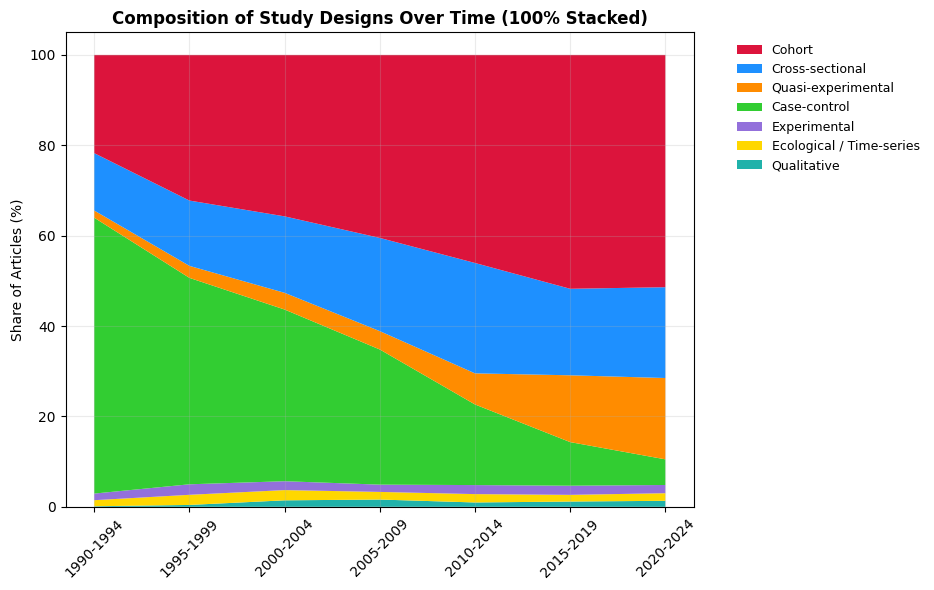

In [116]:
fig, ax1 = plt.subplots(1, 1, figsize=(9.5, 6))

fixed_color_map = {
    'Cohort': '#DC143C',
    'Cross-sectional': '#1E90FF',
    'Quasi-experimental': '#FF8C00',
    'Case-control': '#32CD32',
    'Experimental': '#9370DB',
    'Ecological / Time-series': '#FFD700',
    'Qualitative': '#20B2AA',
}

available_cols = [c for c in DESIGN_HIERARCHY if c in temporal_pivot.columns]
ct = temporal_pivot[available_cols].copy()
ct_pct = (ct.div(ct.sum(axis=1), axis=0) * 100).fillna(0)

order_desc = ct_pct.iloc[-1].sort_values(ascending=False).index.tolist()
order_asc  = order_desc[::-1]

ax1.stackplot(
    range(len(ct_pct.index)),
    *[ct_pct[col].values for col in order_asc],
    labels=order_asc,
    colors=[fixed_color_map[col] for col in order_asc],
)
ax1.set_xticks(range(len(ct_pct.index)))
ax1.set_xticklabels(ct_pct.index, rotation=45)
ax1.set_ylabel('Share of Articles (%)')
ax1.set_title('Composition of Study Designs Over Time (100% Stacked)', fontsize=12, fontweight='bold')

handles, labels = ax1.get_legend_handles_labels()
lab2h = dict(zip(labels, handles))
ax1.legend([lab2h[l] for l in order_desc], order_desc,
           bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, frameon=False)

ax1.grid(True, alpha=0.25)
plt.tight_layout()

plt.savefig(FIGURE_DIR / "composition_of_study_designs_over_time.png")
plt.show() 

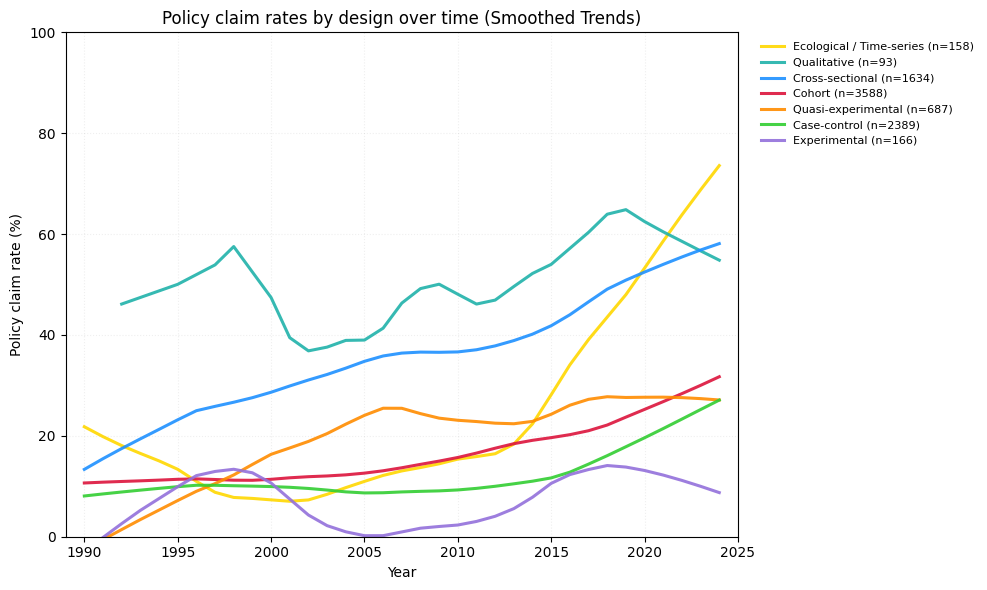

In [117]:
YEAR_COL   = "publication_year"
DESIGN_COL = "design_combined"
CLAIM_COL  = "llm_policy_claim"


yearly_counts = (
    df_filtered.groupby([YEAR_COL, DESIGN_COL])
    .size().reset_index(name="n_articles")
)
yearly_rates = (
    df_filtered.groupby([YEAR_COL, DESIGN_COL])[CLAIM_COL]
    .mean().mul(100).reset_index(name="rate")
)

rates_p = yearly_rates.pivot(index=YEAR_COL, columns=DESIGN_COL, values="rate")
counts_p = yearly_counts.pivot(index=YEAR_COL, columns=DESIGN_COL, values="n_articles").fillna(0)

# legend/order by the most recent available rate
recent = {d: (rates_p[d].dropna().iloc[-1] if d in rates_p else -np.inf) for d in rates_p.columns}
ordered = sorted(recent, key=recent.get, reverse=True)

# --- plot ---
fig, ax = plt.subplots(figsize=(10, 6))
for d in ordered:
    if d not in rates_p: 
        continue
    y = rates_p[d].dropna()
    if len(y) < 3:
        continue
    years = y.index.values
    vals  = y.values
    n_tot = counts_p[d].reindex(y.index).sum()

    try:
        frac = max(0.25, min(0.4, 15/len(y)))
        sm = lowess(vals, years, frac=frac, return_sorted=True)
        ax.plot(sm[:, 0], sm[:, 1], linewidth=2.2, alpha=0.9,
                color=fixed_color_map.get(d), label=f"{d} (n={int(n_tot)})")
    except Exception:
        ax.plot(years, vals, linewidth=1.8, alpha=0.85,
                color=fixed_color_map.get(d), label=f"{d} (n={int(n_tot)})")

ax.set_xlim(rates_p.index.min()-1, rates_p.index.max()+1)
ax.set_ylim(0, 100)
ax.set_xlabel("Year"); ax.set_ylabel("Policy claim rate (%)")
ax.set_title("Policy claim rates by design over time (Smoothed Trends)")
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False, fontsize=8)
ax.grid(True, alpha=0.2, linestyle=":")
plt.tight_layout()

plt.savefig(FIGURE_DIR / "policy_claim_rates_by_design_over_time_smoothed.png")
plt.show() 

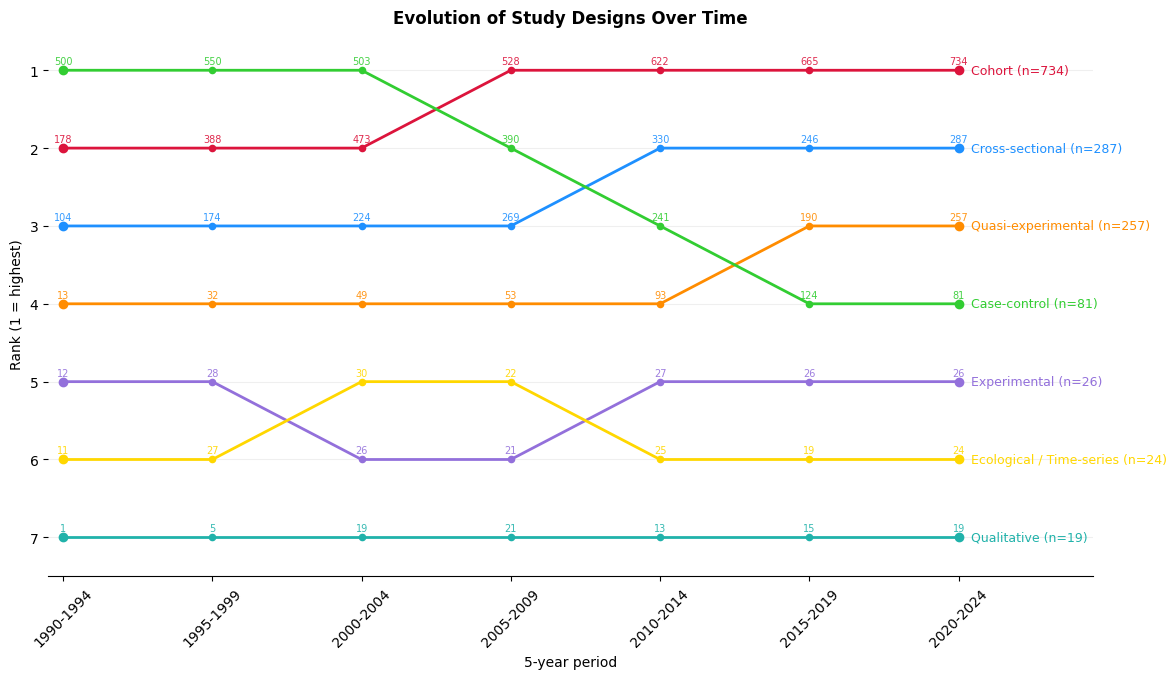

In [118]:
# counts -> rank
available = [d for d in DESIGN_HIERARCHY if d in temporal_pivot.columns]
ct_counts = temporal_pivot[available].fillna(0).astype(float)
rank_df = ct_counts.rank(axis=1, method="first", ascending=False).astype(int)
final_order = rank_df.loc[rank_df.index[-1]].sort_values().index.tolist()

import numpy as np, matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, max(6, 0.7*len(final_order)+2)))
x = np.arange(len(rank_df.index))

for d in final_order:
    y = rank_df[d].values
    c = fixed_color_map.get(d, None)
    ax.plot(x, y, linewidth=2, color=c)
    ax.scatter([x[0], x[-1]], [y[0], y[-1]], s=36, zorder=3, color=c)
    ax.text(x[-1]+0.08, y[-1], f"{d} (n={int(ct_counts.iloc[-1][d])})",
            ha="left", va="center", fontsize=9, color=c)
    
    ax.scatter(x, y, s=20, color=c, zorder=3)          
    for i, xi in enumerate(x):
        n_i = int(ct_counts.iloc[i][d]) if d in ct_counts.columns else 0
        ax.text(xi, y[i]-0.18, f"{n_i}",                   
                ha="center", va="top", fontsize=7, color=c, alpha=0.9)

ax.set_xlim(-0.1, x[-1] + 0.9)
ax.set_xticks(x); ax.set_xticklabels(rank_df.index, rotation=45)
ax.invert_yaxis()
ax.set_ylim(len(final_order)+0.5, 0.5)
ax.set_yticks(range(1, len(final_order)+1))
ax.set_ylabel("Rank (1 = highest)"); ax.set_xlabel("5-year period")
ax.set_title("Evolution of Study Designs Over Time", fontsize=12, fontweight="bold")
for s in ["top","right","left"]: ax.spines[s].set_visible(False)
ax.grid(axis="y", alpha=0.2)
plt.tight_layout()

plt.savefig(FIGURE_DIR / "evolution_of_study_designs_over_time_rank.png")
plt.show() 


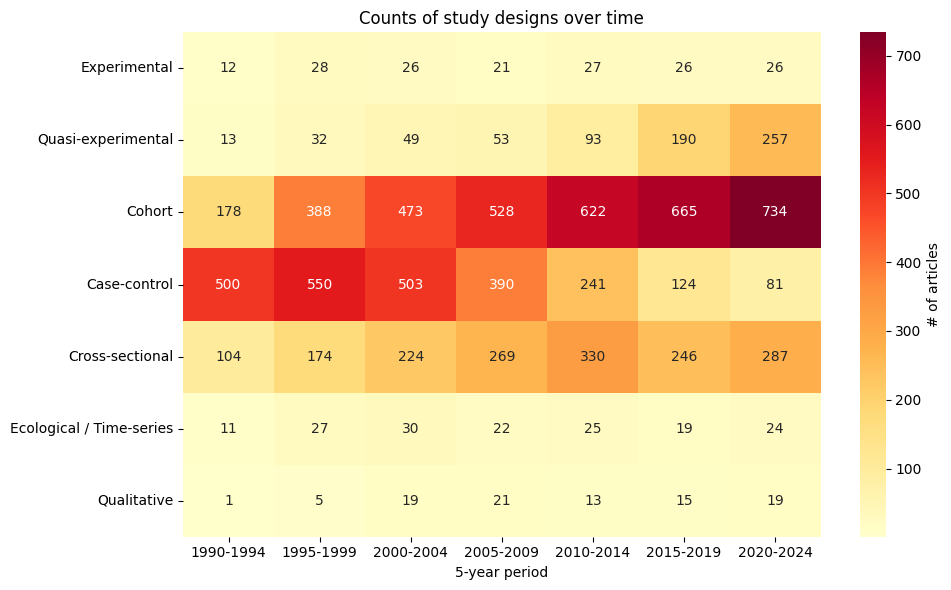

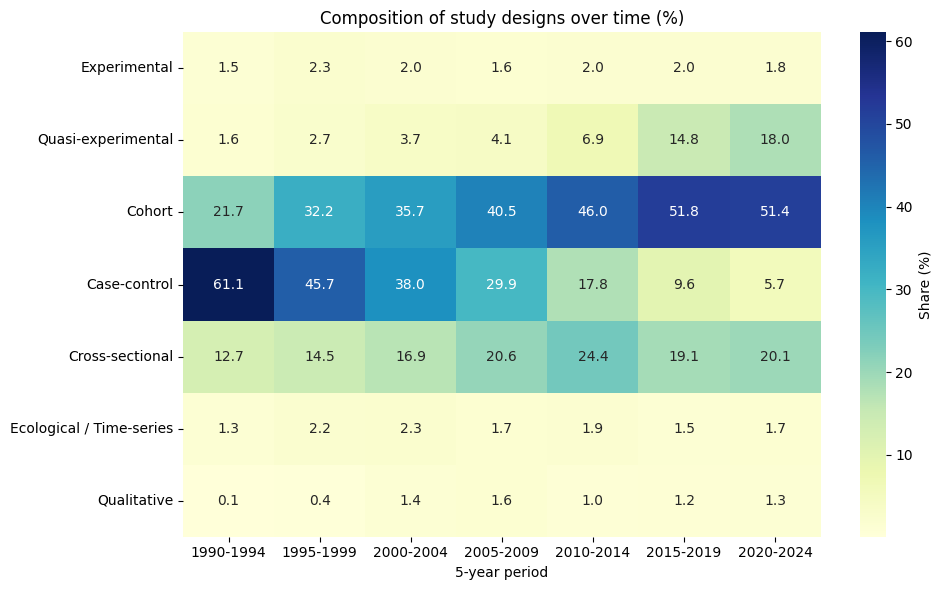

In [119]:
import seaborn as sns
ct = temporal_pivot[available].fillna(0)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(ct.T, cmap="YlOrRd", annot=True, fmt=".0f", cbar_kws={"label":"# of articles"}, ax=ax)
ax.set_xlabel("5-year period"); ax.set_ylabel(""); ax.set_title("Counts of study designs over time")
plt.tight_layout()
plt.savefig(FIGURE_DIR / "counts_of_study_design_over_time_heatmap.png")
plt.show() 

ct_pct = (ct.div(ct.sum(axis=1), axis=0) * 100).fillna(0)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(ct_pct.T, cmap="YlGnBu", annot=True, fmt=".1f", cbar_kws={"label":"Share (%)"}, ax=ax)
ax.set_xlabel("5-year period"); ax.set_ylabel(""); ax.set_title("Composition of study designs over time (%)")
plt.tight_layout()

plt.savefig(FIGURE_DIR / "percentage_of_study_design_over_time_heatmap.png")
plt.show() 


# Fig 5 - keywords analysis...(topic of study)

## tables...

In [120]:
def process_keywords(keyword_data):
    if pd.isna(keyword_data):
        return []
    if isinstance(keyword_data, list):
        cleaned = [str(k).lower().strip().strip("'\"") for k in keyword_data if k and str(k).strip()]
        return [k for k in cleaned if k and k != '[]' and len(k) > 1]
    if isinstance(keyword_data, str):
        if keyword_data.strip() in ['', '[]', '[ ]', None]:
            return []
        pattern = r"'([^']*)'"
        keywords = re.findall(pattern, keyword_data)
        if not keywords:
            pattern = r'"([^"]*)"'
            keywords = re.findall(pattern, keyword_data)
        if not keywords and keyword_data.strip() != '[]':
            keywords = [k.strip() for k in keyword_data.split(',')]
        keywords = [k.lower().strip() for k in keywords if k.strip() and len(k.strip()) > 1]
        return keywords
    return []

df['keywords_clean'] = df['keywords'].apply(process_keywords)
df['keyword_count'] = df['keywords_clean'].apply(len)
df_with_keywords = df[df['keyword_count'] > 0].copy()

In [121]:
from collections import Counter

all_keywords = [kw for kws in df_with_keywords['keywords_clean'] for kw in kws]

keyword_counts = Counter(all_keywords)

top_40 = keyword_counts.most_common(40)

print("="*70)
print("TOP 40 MOST COMMON KEYWORDS IN THE CORPUS")
print("="*70)
print()

n_papers_with_keywords = len(df_with_keywords)
for i, (kw, count) in enumerate(top_40, 1):
    pct = 100 * count / n_papers_with_keywords
    print(f"{i:2d}. {kw.title():<30s} n={count:>6,}  ({pct:>5.1f}% of papers)")

print(f"\nTotal papers with keywords: {n_papers_with_keywords:,}")
print(f"Total unique keywords: {len(keyword_counts):,}")

TOP 40 MOST COMMON KEYWORDS IN THE CORPUS

 1. Mortality                      n= 1,664  (  6.9% of papers)
 2. Smoking                        n= 1,373  (  5.7% of papers)
 3. Epidemiology                   n= 1,200  (  5.0% of papers)
 4. Risk Factors                   n= 1,135  (  4.7% of papers)
 5. Obesity                        n= 1,091  (  4.5% of papers)
 6. Cohort Studies                 n=   995  (  4.1% of papers)
 7. Physical Activity              n=   904  (  3.8% of papers)
 8. Epidemiologic Methods          n=   837  (  3.5% of papers)
 9. Pregnancy                      n=   717  (  3.0% of papers)
10. Body Mass Index                n=   680  (  2.8% of papers)
11. Diet                           n=   673  (  2.8% of papers)
12. Case-Control Studies           n=   632  (  2.6% of papers)
13. Exercise                       n=   536  (  2.2% of papers)
14. Cohort Study                   n=   488  (  2.0% of papers)
15. Child                          n=   443  (  1.8% of paper

## keywords plots x 2


TABLE 1: MOST COMMON KEYWORDS (Left Panel)
               Keyword  Total Papers  Policy Claims  No Policy Claims  Policy Claim Rate (%)
               Tobacco          1920            505              1415                   26.3
             Mortality          1664            263              1401                   15.8
     Physical Activity          1526            387              1139                   25.4
               Obesity          1268            281               987                   22.2
          Epidemiology          1200            265               935                   22.1
          Risk Factors          1135            212               923                   18.7
Cardiovascular Disease          1091            170               921                   15.6
        Cohort Studies           995             96               899                    9.6
 Epidemiologic Methods           837             33               804                    3.9
             Pregnancy    

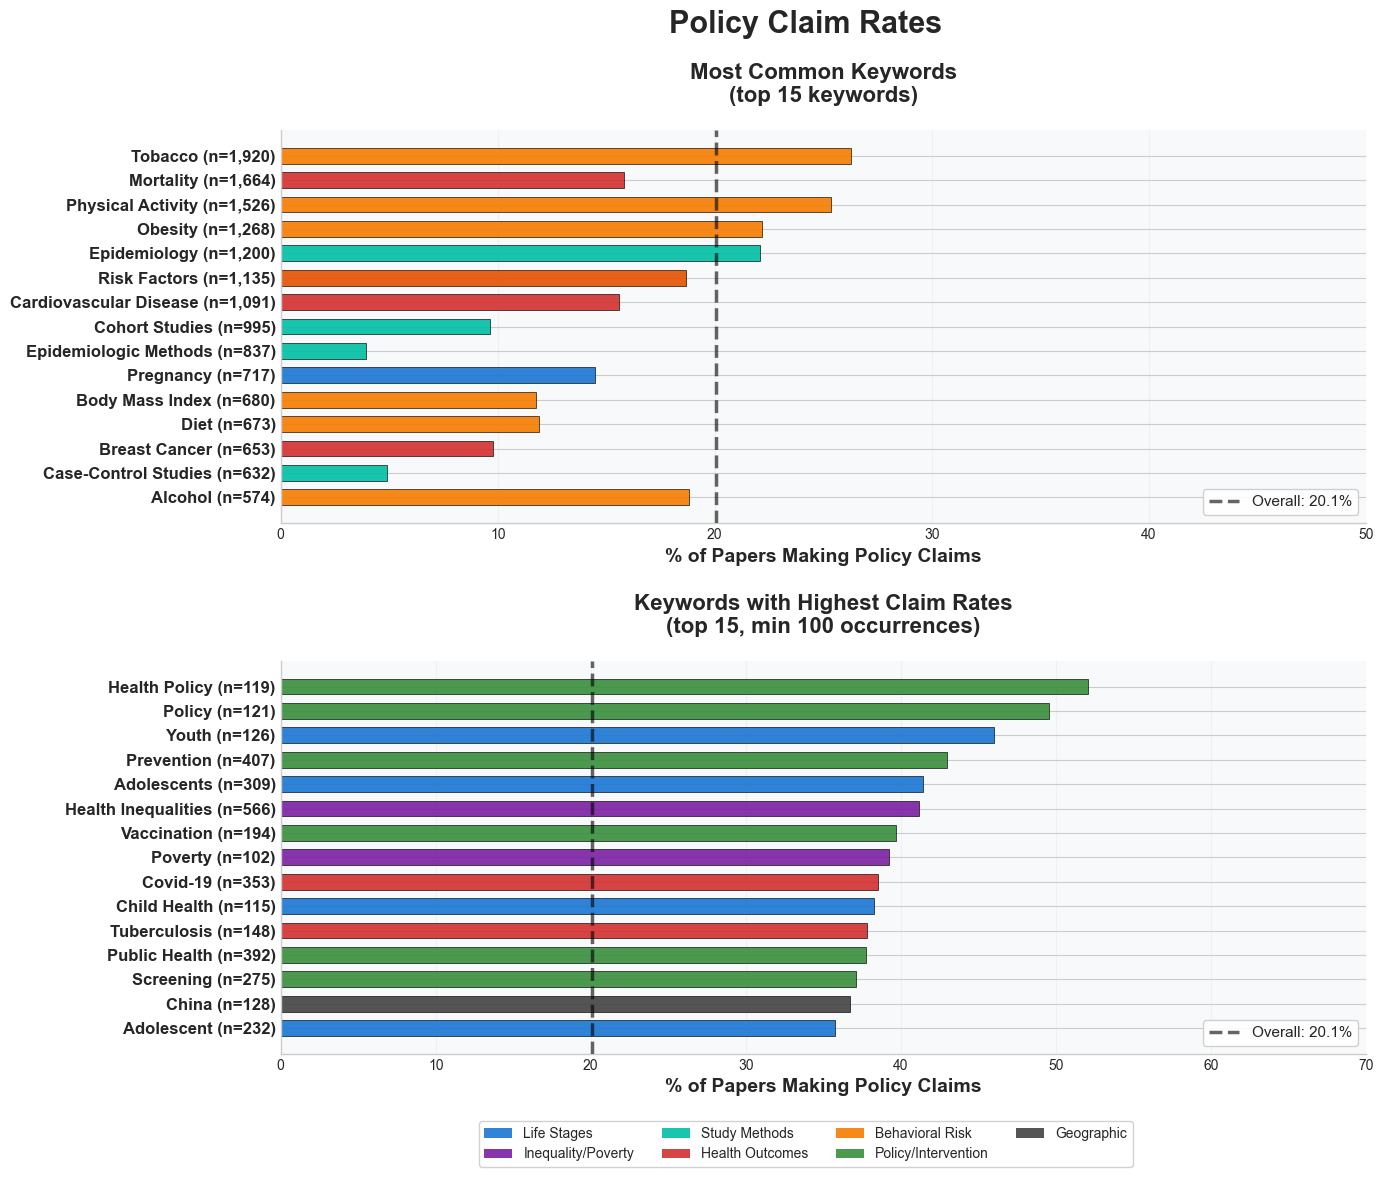

In [122]:
# Keyword Analysis and Visualization
# Keyword Analysis and Visualization (Optimised Colours)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import re
import pandas as pd
from matplotlib.patches import Patch

# --- PLOT SETUP ---
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(14, 12))  
gs = fig.add_gridspec(2, 1, height_ratios=[1, 1], hspace=0.35)  
axes = [fig.add_subplot(gs[i, 0]) for i in range(2)]
fig.suptitle('Policy Claim Rates', fontsize=22, fontweight='bold', y=0.98)

# --- KEYWORD PROCESSING ---
def process_keywords(keyword_data):
    """Extract and clean keywords from various formats"""
    if pd.isna(keyword_data):
        return []
    if isinstance(keyword_data, list):
        cleaned = [str(k).lower().strip().strip("'\"") for k in keyword_data if k and str(k).strip()]
        return [k for k in cleaned if k and k != '[]' and len(k) > 1]
    if isinstance(keyword_data, str):
        if keyword_data.strip() in ['', '[]', '[ ]', None]:
            return []
        pattern = r"'([^']*)'"
        keywords = re.findall(pattern, keyword_data)
        if not keywords:
            pattern = r'"([^"]*)"'
            keywords = re.findall(pattern, keyword_data)
        if not keywords and keyword_data.strip() != '[]':
            keywords = [k.strip() for k in keyword_data.split(',')]
        keywords = [k.lower().strip() for k in keywords if k.strip() and len(k.strip()) > 1]
        return keywords
    return []

# --- CONSOLIDATION MAPPING ---
keyword_mapping = {
    # Health inequalities cluster
    'health inequalities': 'health inequalities',
    'health disparities': 'health inequalities',
    'disparities': 'health inequalities',
    'social inequalities': 'health inequalities',
    'inequalities': 'health inequalities',
    'healthcare disparities': 'health inequalities',

    # Tobacco cluster (under Behavioral Risk)
    'tobacco use': 'tobacco',
    'tobacco control': 'tobacco',
    'smoking': 'tobacco',
    'cigarette smoking': 'tobacco',

    # Violence cluster
    'domestic violence': 'domestic violence',
    'intimate partner violence': 'domestic violence',
    'partner violence': 'domestic violence',
    'family violence': 'domestic violence',
    'spouse abuse': 'domestic violence',

    # Physical activity cluster
    'physical activity': 'physical activity',
    'exercise': 'physical activity',
    'motor activity': 'physical activity',

    # Obesity cluster
    'obesity': 'obesity',
    'overweight': 'obesity',

    # Cancer types
    'breast neoplasms': 'breast cancer',
    'breast cancer': 'breast cancer',
    'colorectal neoplasms': 'colorectal cancer',
    'colorectal cancer': 'colorectal cancer',
    'lung neoplasms': 'lung cancer',
    'lung cancer': 'lung cancer',
    'cervical cancer': 'cervical cancer',
    'cervical neoplasms': 'cervical cancer',

    # Cardiovascular
    'cardiovascular diseases': 'cardiovascular disease',
    'cardiovascular disease': 'cardiovascular disease',
    'heart disease': 'cardiovascular disease',
    'coronary disease': 'cardiovascular disease',

    # Diabetes
    'diabetes mellitus': 'diabetes',
    'diabetes': 'diabetes',

    # Mental health
    'mental health': 'mental health',
    'mental disorders': 'mental health',
    'depression': 'depression',
    'depressive disorder': 'depression',

    # Alcohol
    'alcohol drinking': 'alcohol',
    'alcoholism': 'alcohol',
    'alcohol': 'alcohol',
}

# --- OPTIMISED COLOUR SCHEME (Swapped life stages and study methods) ---
keyword_colors = {
    # Life stages – NOW Bright blue (was study methods color)
    'child': '#1976D2',
    'adolescent': '#1976D2',
    'adolescents': '#1976D2',
    'youth': '#1976D2',
    'pregnancy': '#1976D2',
    'aged': '#1976D2',
    'child health': '#1976D2',

    # Inequality/socioeconomic – Deep purple
    'health inequalities': '#7B1FA2',
    'poverty': '#7B1FA2',

    # Study methods – NOW Vibrant teal (was life stages color)
    'epidemiology': '#00BFA5',
    'cohort studies': '#00BFA5',
    'case-control studies': '#00BFA5',
    'epidemiologic methods': '#00BFA5',
    'cohort study': '#00BFA5',
    'surveillance': '#00BFA5',

    # Health outcomes – Bright red
    'mortality': '#D32F2F',
    'morbidity': '#D32F2F',
    'incidence': '#D32F2F',
    'cardiovascular disease': '#D32F2F',
    'diabetes': '#D32F2F',
    'breast cancer': '#D32F2F',
    'cervical cancer': '#D32F2F',
    'tuberculosis': '#D32F2F',
    'covid-19': '#D32F2F',

    # Behavioral risk – Orange
    'obesity': '#F57C00',
    'physical activity': '#F57C00',
    'diet': '#F57C00',
    'body mass index': '#F57C00',
    'tobacco': '#F57C00',
    'smoking': '#F57C00',
    'alcohol': '#F57C00',

    # Policy/intervention – Forest green
    'prevention': '#388E3C',
    'screening': '#388E3C',
    'vaccination': '#388E3C',
    'health policy': '#388E3C',
    'policy': '#388E3C',
    'public health': '#388E3C',

    # Geographic – Dark gray
    'china': '#424242',
    'europe': '#424242',
    'canada': '#424242',

    # Violence – Deep burgundy
    'violence': '#922b21',
    'domestic violence': '#922b21',

    # Risk – Dark amber
    'risk factors': '#E65100',
}

def get_keyword_color(keyword):
    """Return color for keyword based on theme, or default gray"""
    return keyword_colors.get(keyword.lower(), '#95a5a6')

def consolidate_keywords(keywords):
    """Apply keyword consolidation mapping"""
    consolidated = []
    for kw in keywords:
        mapped_kw = keyword_mapping.get(kw, kw)
        consolidated.append(mapped_kw)
    return consolidated

# --- APPLY PROCESSING ---
df['keywords_clean'] = df['keywords'].apply(process_keywords)
df['keywords_clean'] = df['keywords_clean'].apply(consolidate_keywords)
df['keyword_count'] = df['keywords_clean'].apply(len)
df_with_keywords = df[df['keyword_count'] > 0].copy()

policy_df = df_with_keywords[df_with_keywords['llm_policy_claim'] == 1].copy()
non_policy_df = df_with_keywords[df_with_keywords['llm_policy_claim'] == 0].copy()

# --- COUNTING ---
policy_keywords = [kw for keywords in policy_df['keywords_clean'] for kw in keywords]
non_policy_keywords = [kw for keywords in non_policy_df['keywords_clean'] for kw in keywords]
policy_counter = Counter(policy_keywords)
non_policy_counter = Counter(non_policy_keywords)

invalid_entries = ['', '[]', '[ ]', None]
for invalid in invalid_entries:
    policy_counter.pop(invalid, None)
    non_policy_counter.pop(invalid, None)

MIN_OCCURRENCES = 5
MIN_OCCURRENCES_MIDDLE = 100
policy_color = '#c0392b'
non_policy_color = '#2980b9'

# --- POLICY CLAIM RATE BY KEYWORD ---
top_n = 15
all_valid_keywords = {}
for keyword in set(list(policy_counter.keys()) + list(non_policy_counter.keys())):
    total = policy_counter.get(keyword, 0) + non_policy_counter.get(keyword, 0)
    if total >= MIN_OCCURRENCES:
        all_valid_keywords[keyword] = total

keyword_policy_rates = []
for keyword, total_count in all_valid_keywords.items():
    policy_count = policy_counter.get(keyword, 0)
    policy_rate = (policy_count / total_count) * 100
    keyword_policy_rates.append((keyword, policy_rate, total_count))

keyword_policy_rates.sort(key=lambda x: x[2], reverse=True)
top_keywords = keyword_policy_rates[:top_n]

# --- PLOT LEFT PANEL ---
if top_keywords:
    keywords, policy_rates, total_counts = zip(*top_keywords)
    y_pos = np.arange(len(keywords))
    colors = [get_keyword_color(kw) for kw in keywords]
    axes[0].barh(y_pos, policy_rates, height=0.65, color=colors,
                 alpha=0.9, edgecolor='black', linewidth=0.5)
    labels = [f"{kw.title()} (n={tc:,})" for kw, tc in zip(keywords, total_counts)]
    axes[0].set_yticks(y_pos)
    axes[0].set_yticklabels(labels, fontsize=12, fontweight='bold')
    axes[0].set_xlabel('% of Papers Making Policy Claims', fontsize=14, fontweight='bold')
    axes[0].set_title(f'Most Common Keywords\n(top {top_n} keywords)', fontsize=16, fontweight='bold', pad=20)
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.2)
    axes[0].set_xlim(0, 50)

overall_policy_rate = (len(policy_df) / len(df_with_keywords)) * 100
axes[0].axvline(x=overall_policy_rate, color='black', linestyle='--',
                alpha=0.6, linewidth=2.5, label=f'Overall: {overall_policy_rate:.1f}%', zorder=10)
axes[0].legend(loc='lower right', fontsize=11, frameon=True, framealpha=0.9)

# --- RIGHT PANEL (Highest policy claim rates) ---
high_freq_keywords = {k: v for k, v in all_valid_keywords.items() if v >= MIN_OCCURRENCES_MIDDLE}
high_freq_rates = []
for keyword, total_count in high_freq_keywords.items():
    policy_count = policy_counter.get(keyword, 0)
    policy_rate = (policy_count / total_count) * 100
    high_freq_rates.append((keyword, policy_rate, total_count))

high_freq_rates.sort(key=lambda x: x[1], reverse=True)
top_by_rate = high_freq_rates[:top_n]

if top_by_rate:
    keywords, policy_rates, total_counts = zip(*top_by_rate)
    y_pos = np.arange(len(keywords))
    colors = [get_keyword_color(kw) for kw in keywords]
    axes[1].barh(y_pos, policy_rates, height=0.65, color=colors,
                 alpha=0.9, edgecolor='black', linewidth=0.5)
    labels = [f"{kw.title()} (n={tc:,})" for kw, tc in zip(keywords, total_counts)]
    axes[1].set_yticks(y_pos)
    axes[1].set_yticklabels(labels, fontsize=12,fontweight='bold')
    axes[1].set_xlabel('% of Papers Making Policy Claims', fontsize=14, fontweight='bold')
    axes[1].set_title(f'Keywords with Highest Claim Rates\n(top 15, min {MIN_OCCURRENCES_MIDDLE} occurrences)',
                      fontsize=16, fontweight='bold', pad=20)
    axes[1].axvline(x=overall_policy_rate, color='black', linestyle='--',
                    alpha=0.6, linewidth=2.5, label=f'Overall: {overall_policy_rate:.1f}%', zorder=10)
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.2)
    axes[1].set_xlim(0, 70)
    axes[1].legend(loc='lower right', fontsize=11, frameon=True, framealpha=0.9)

# --- STYLE & LEGEND (Only show categories present in plots) ---
for ax in axes:
    ax.set_facecolor('#f8f9fa')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Collect all keywords actually shown in both plots
shown_keywords = set()
if top_keywords:
    shown_keywords.update([kw for kw, _, _ in top_keywords])
if top_by_rate:
    shown_keywords.update([kw for kw, _, _ in top_by_rate])

# Determine which categories are present
categories_present = set()
category_map = {
    '#1976D2': 'Life Stages',
    '#7B1FA2': 'Inequality/Poverty',
    '#00BFA5': 'Study Methods',
    '#D32F2F': 'Health Outcomes',
    '#F57C00': 'Behavioral Risk',
    '#388E3C': 'Policy/Intervention',
    '#424242': 'Geographic',
    '#922b21': 'Violence',
}

for kw in shown_keywords:
    color = get_keyword_color(kw)
    if color in category_map:
        categories_present.add((color, category_map[color]))

# Sort to maintain consistent order
categories_present = sorted(categories_present, key=lambda x: list(category_map.values()).index(x[1]))

# Create legend with only present categories
legend_elements = [Patch(facecolor=color, label=label, alpha=0.9) 
                   for color, label in categories_present]

fig.legend(handles=legend_elements,
           loc='lower center',
           ncol=min(4, len(legend_elements)),
           fontsize=10, frameon=True, framealpha=0.9,
           bbox_to_anchor=(0.5, 0.01))

plt.tight_layout(rect=[0, 0.04, 1, 0.95]) 

# --- CREATE SUMMARY TABLES ---
# Left panel data (Most Common Keywords)
left_panel_data = []
for kw, rate, count in top_keywords:
    policy_count = policy_counter.get(kw, 0)
    non_policy_count = non_policy_counter.get(kw, 0)
    left_panel_data.append({
        'Keyword': kw.title(),
        'Total Papers': count,
        'Policy Claims': policy_count,
        'No Policy Claims': non_policy_count,
        'Policy Claim Rate (%)': round(rate, 1)
    })

# Right panel data (Highest Claim Rates)
right_panel_data = []
for kw, rate, count in top_by_rate:
    policy_count = policy_counter.get(kw, 0)
    non_policy_count = non_policy_counter.get(kw, 0)
    right_panel_data.append({
        'Keyword': kw.title(),
        'Total Papers': count,
        'Policy Claims': policy_count,
        'No Policy Claims': non_policy_count,
        'Policy Claim Rate (%)': round(rate, 1)
    })

# Create DataFrames
left_df = pd.DataFrame(left_panel_data)
right_df = pd.DataFrame(right_panel_data)

# --- DISPLAY TABLES ---
print("\n" + "="*90)
print("TABLE 1: MOST COMMON KEYWORDS (Left Panel)")
print("="*90)
print(left_df.to_string(index=False))

print("\n" + "="*90)
print(f"TABLE 2: KEYWORDS WITH HIGHEST POLICY CLAIM RATES (Right Panel, min {MIN_OCCURRENCES_MIDDLE} occurrences)")
print("="*90)
print(right_df.to_string(index=False))

# --- SUMMARY ---
print("\n" + "="*90)
print("KEY INSIGHTS FROM KEYWORD ANALYSIS")
print("="*90)
print(f"\nOverall policy claim rate: {overall_policy_rate:.1f}%")
print(f"Total papers with keywords: {len(df_with_keywords):,}")
print(f"Papers making policy claims: {len(policy_df):,}")
print(f"Papers not making policy claims: {len(non_policy_df):,}")
print(f"\nTop 5 keywords with highest policy claim rates (min {MIN_OCCURRENCES_MIDDLE} occurrences):")
for i, (kw, rate, count) in enumerate(high_freq_rates[:5], 1):
    print(f"  {i}. {kw}: {rate:.1f}% of {count} papers make policy claims")


plt.savefig(FIGURE_DIR / "policy_claim_rates_keywords.png")
plt.show() 

In [170]:
import pandas as pd
import re

CSV_PATH = "../data/sampled_policy_claims_overall_2020_2024_classified_specific_broad - sampled_policy_claims_overall_2020_2024_classified_specific_broad.csv"
COL = "Agreed suggested categories"

df_EC = pd.read_csv(CSV_PATH)
s = df_EC[COL].dropna().astype(str)

# 1) Print all distinct raw cell strings (as entered in CSV)
print(f"Distinct RAW cell strings in '{COL}': {len(s.unique())}")
for v in sorted(s.unique()):
    print(f"- {v}")

Distinct RAW cell strings in 'Agreed suggested categories': 10
- Alternative policy
- Call for action
- Call for further investment in existing policy
- Extension of existing policy
- Focus on specific subgroups
- Not a policy claim
- alternative policy
- focus on specific subgroups
- new evidence for policymaking
- not a policy claim


In [171]:
def split_labels(text):
    parts = re.split(r"[;|,]", str(text))
    out = []
    for p in parts:
        p = p.strip().strip("'\"")
        if p:
            out.append(p)
    return out

expl = df_EC[[COL]].dropna().copy()
expl["_label_raw"] = s.apply(split_labels)
expl = expl.explode("_label_raw").dropna(subset=["_label_raw"]).copy()

mapping = {
    "focus on specific subgroups": "Focus on specific subgroups",
    "not a policy claim": "Not a policy claim",
    "methods paper / not a policy claim": "Not a policy claim",
    "call for action": "Call for action",
    "call for further investment in existing policy": "Call for further investment in existing policy",
    "methods recommendation": "Methods recommendation",
    "new evidence for policymaking": "New evidence for policymaking",
    "alternative policy": "Alternative policy",
    "extension of existing policy": "Extension of existing policy",
}

expl["_canon"] = expl["_label_raw"].str.lower().str.strip().map(mapping)

unknown = expl[expl["_canon"].isna()]["_label_raw"].value_counts()
if len(unknown) > 0:
    print("Unmapped labels (please add to mapping):")
    print(unknown)
else:
    print("All labels mapped OK.")

ct = expl["_canon"].value_counts().rename_axis("_canon").reset_index(name="n")
den = int(ct["n"].sum())
ct["percent"] = (ct["n"] / den * 100).round(1)

print(f"\nDenominator (sum of labels) = {den}")
print(ct)

All labels mapped OK.

Denominator (sum of labels) = 100
                                           _canon   n  percent
0                              Alternative policy  38     38.0
1                     Focus on specific subgroups  27     27.0
2                   New evidence for policymaking  25     25.0
3                                 Call for action   5      5.0
4                              Not a policy claim   3      3.0
5  Call for further investment in existing policy   1      1.0
6                    Extension of existing policy   1      1.0


## keywords by year


TEMPORAL EVOLUTION OF POLICY CLAIM RATES

1990-1999: 13.1% policy claim rate (678/5,159 papers)

2000-2009: 18.4% policy claim rate (1,399/7,587 papers)

2010-2019: 22.5% policy claim rate (1,571/6,972 papers)

2020-2024: 27.4% policy claim rate (1,166/4,263 papers)


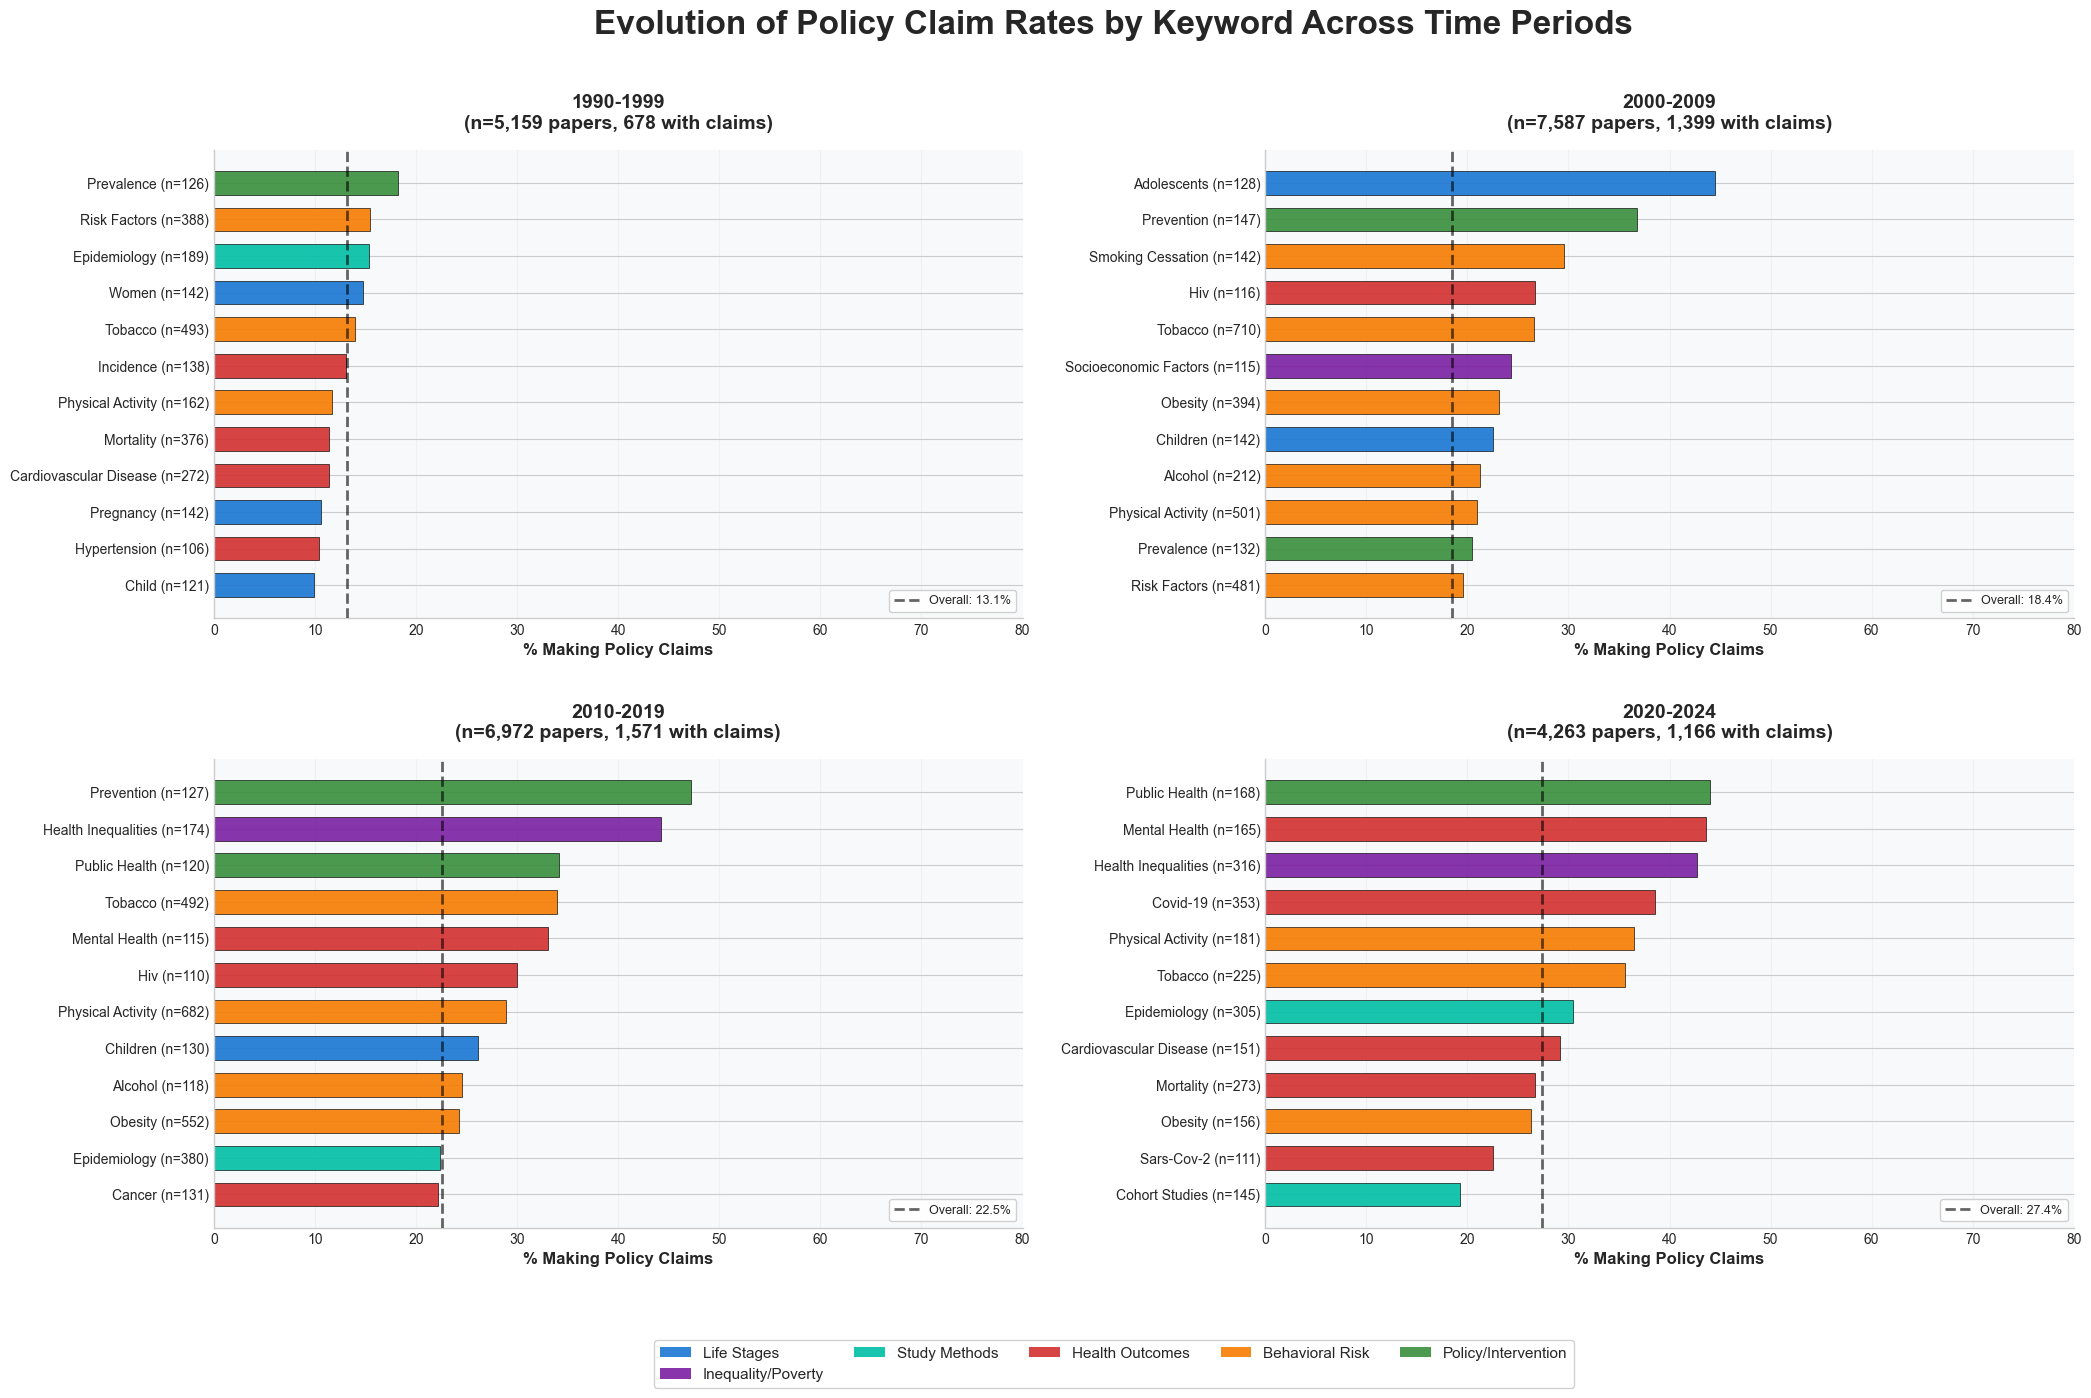

In [125]:
# Temporal Analysis of Policy Claim Rates by Keyword
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import re
import pandas as pd
from matplotlib.patches import Patch

# --- PLOT SETUP ---
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(24, 14))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
axes = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(4)]
fig.suptitle('Evolution of Policy Claim Rates by Keyword Across Time Periods', 
             fontsize=24, fontweight='bold', y=0.98)

# --- KEYWORD PROCESSING (same as original) ---
def process_keywords(keyword_data):
    """Extract and clean keywords from various formats"""
    if pd.isna(keyword_data):
        return []
    if isinstance(keyword_data, list):
        cleaned = [str(k).lower().strip().strip("'\"") for k in keyword_data if k and str(k).strip()]
        return [k for k in cleaned if k and k != '[]' and len(k) > 1]
    if isinstance(keyword_data, str):
        if keyword_data.strip() in ['', '[]', '[ ]', None]:
            return []
        pattern = r"'([^']*)'"
        keywords = re.findall(pattern, keyword_data)
        if not keywords:
            pattern = r'"([^"]*)"'
            keywords = re.findall(pattern, keyword_data)
        if not keywords and keyword_data.strip() != '[]':
            keywords = [k.strip() for k in keyword_data.split(',')]
        keywords = [k.lower().strip() for k in keywords if k.strip() and len(k.strip()) > 1]
        return keywords
    return []

# --- CONSOLIDATION MAPPING (same as original) ---
keyword_mapping = {
    'health inequalities': 'health inequalities',
    'health disparities': 'health inequalities',
    'disparities': 'health inequalities',
    'social inequalities': 'health inequalities',
    'inequalities': 'health inequalities',
    'healthcare disparities': 'health inequalities',
    'tobacco use': 'tobacco',
    'tobacco control': 'tobacco',
    'smoking': 'tobacco',
    'cigarette smoking': 'tobacco',
    'domestic violence': 'domestic violence',
    'intimate partner violence': 'domestic violence',
    'partner violence': 'domestic violence',
    'family violence': 'domestic violence',
    'spouse abuse': 'domestic violence',
    'physical activity': 'physical activity',
    'exercise': 'physical activity',
    'motor activity': 'physical activity',
    'obesity': 'obesity',
    'overweight': 'obesity',
    'breast neoplasms': 'breast cancer',
    'breast cancer': 'breast cancer',
    'colorectal neoplasms': 'colorectal cancer',
    'colorectal cancer': 'colorectal cancer',
    'lung neoplasms': 'lung cancer',
    'lung cancer': 'lung cancer',
    'cervical cancer': 'cervical cancer',
    'cervical neoplasms': 'cervical cancer',
    'cardiovascular diseases': 'cardiovascular disease',
    'cardiovascular disease': 'cardiovascular disease',
    'heart disease': 'cardiovascular disease',
    'coronary disease': 'cardiovascular disease',
    'diabetes mellitus': 'diabetes',
    'diabetes': 'diabetes',
    'mental health': 'mental health',
    'mental disorders': 'mental health',
    'depression': 'depression',
    'depressive disorder': 'depression',
    'alcohol drinking': 'alcohol',
    'alcoholism': 'alcohol',
    'alcohol': 'alcohol',
}

# --- COLOUR SCHEME (same as original) ---
keyword_colors = {
    # Life stages
    'child': '#1976D2', 'adolescent': '#1976D2', 'adolescents': '#1976D2',
    'youth': '#1976D2', 'pregnancy': '#1976D2', 'aged': '#1976D2', 'child health': '#1976D2',
    'children': '#1976D2', 'women': '#1976D2',
    
    # Inequality/Poverty
    'health inequalities': '#7B1FA2', 'poverty': '#7B1FA2', 'socioeconomic factors': '#7B1FA2',
    
    # Study Methods
    'epidemiology': '#00BFA5', 'cohort studies': '#00BFA5', 'case-control studies': '#00BFA5',
    'epidemiologic methods': '#00BFA5', 'cohort study': '#00BFA5', 'surveillance': '#00BFA5',
    
    # Health Outcomes
    'mortality': '#D32F2F', 'morbidity': '#D32F2F', 'incidence': '#D32F2F',
    'cardiovascular disease': '#D32F2F', 'diabetes': '#D32F2F', 'breast cancer': '#D32F2F',
    'cervical cancer': '#D32F2F', 'tuberculosis': '#D32F2F', 'covid-19': '#D32F2F',
    'hiv': '#D32F2F', 'mental health': '#D32F2F', 'cancer': '#D32F2F', 
    'hypertension': '#D32F2F', 'sars-cov-2': '#D32F2F',
    
    # Behavioral Risk
    'obesity': '#F57C00', 'physical activity': '#F57C00', 'diet': '#F57C00',
    'body mass index': '#F57C00', 'tobacco': '#F57C00', 'smoking': '#F57C00', 'alcohol': '#F57C00',
    'risk factors': '#F57C00', 'smoking cessation': '#F57C00',
    
    # Policy/Intervention
    'prevention': '#388E3C', 'screening': '#388E3C', 'vaccination': '#388E3C',
    'health policy': '#388E3C', 'policy': '#388E3C', 'public health': '#388E3C',
    'prevalence': '#388E3C',
    
    # Geographic
    'china': '#424242', 'europe': '#424242', 'canada': '#424242',
    
    # Violence
    'violence': '#922b21', 'domestic violence': '#922b21',
}

def get_keyword_color(keyword):
    return keyword_colors.get(keyword.lower(), '#95a5a6')

def consolidate_keywords(keywords):
    return [keyword_mapping.get(kw, kw) for kw in keywords]

# --- APPLY PROCESSING ---
df['keywords_clean'] = df['keywords'].apply(process_keywords)
df['keywords_clean'] = df['keywords_clean'].apply(consolidate_keywords)
df['keyword_count'] = df['keywords_clean'].apply(len)
df_with_keywords = df[df['keyword_count'] > 0].copy()

# --- TIME PERIODS ---
time_periods = [
    (1990, 1999, '1990-1999'),
    (2000, 2009, '2000-2009'),
    (2010, 2019, '2010-2019'),
    (2020, 2024, '2020-2024')
]

MIN_OCCURRENCES_PERIOD = 100  # Minimum occurrences per period
top_n = 12  # Show top 12 per period

# Store all shown keywords for legend
all_shown_keywords = set()

# --- PROCESS EACH TIME PERIOD ---
for idx, (start_year, end_year, period_label) in enumerate(time_periods):
    ax = axes[idx]
    
    # Filter data for this period
    period_df = df_with_keywords[
        (df_with_keywords['publication_year'] >= start_year) & 
        (df_with_keywords['publication_year'] <= end_year)
    ].copy()
    
    policy_df = period_df[period_df['llm_policy_claim'] == 1]
    non_policy_df = period_df[period_df['llm_policy_claim'] == 0]
    
    # Count keywords
    policy_keywords = [kw for keywords in policy_df['keywords_clean'] for kw in keywords]
    non_policy_keywords = [kw for keywords in non_policy_df['keywords_clean'] for kw in keywords]
    policy_counter = Counter(policy_keywords)
    non_policy_counter = Counter(non_policy_keywords)
    
    # Calculate policy claim rates
    all_valid_keywords = {}
    for keyword in set(list(policy_counter.keys()) + list(non_policy_counter.keys())):
        total = policy_counter.get(keyword, 0) + non_policy_counter.get(keyword, 0)
        if total >= MIN_OCCURRENCES_PERIOD:
            all_valid_keywords[keyword] = total
    
    keyword_policy_rates = []
    for keyword, total_count in all_valid_keywords.items():
        policy_count = policy_counter.get(keyword, 0)
        policy_rate = (policy_count / total_count) * 100
        keyword_policy_rates.append((keyword, policy_rate, total_count))
    
    # Sort by policy rate (descending)
    keyword_policy_rates.sort(key=lambda x: x[1], reverse=True)
    top_keywords = keyword_policy_rates[:top_n]
    
    # Calculate overall rate for this period
    overall_policy_rate = (len(policy_df) / len(period_df)) * 100 if len(period_df) > 0 else 0
    
    # Plot
    if top_keywords:
        keywords, policy_rates, total_counts = zip(*top_keywords)
        all_shown_keywords.update(keywords)
        y_pos = np.arange(len(keywords))
        colors = [get_keyword_color(kw) for kw in keywords]
        
        ax.barh(y_pos, policy_rates, height=0.65, color=colors,
                alpha=0.9, edgecolor='black', linewidth=0.5)
        
        labels = [f"{kw.title()} (n={tc:,})" for kw, tc in zip(keywords, total_counts)]
        ax.set_yticks(y_pos)
        ax.set_yticklabels(labels, fontsize=10)
        ax.set_xlabel('% Making Policy Claims', fontsize=12, fontweight='bold')
        ax.set_title(f'{period_label}\n(n={len(period_df):,} papers, {len(policy_df):,} with claims)',
                    fontsize=14, fontweight='bold', pad=15)
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.2)
        ax.set_xlim(0, 80)
        
        # Add overall rate line
        ax.axvline(x=overall_policy_rate, color='black', linestyle='--',
                  alpha=0.6, linewidth=2, label=f'Overall: {overall_policy_rate:.1f}%', zorder=10)
        ax.legend(loc='lower right', fontsize=9, frameon=True, framealpha=0.9)
        
        ax.set_facecolor('#f8f9fa')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    else:
        ax.text(0.5, 0.5, f'Insufficient data for {period_label}',
               ha='center', va='center', fontsize=14, transform=ax.transAxes)
        ax.set_xticks([])
        ax.set_yticks([])

# --- LEGEND ---
category_map = {
    '#1976D2': 'Life Stages',
    '#7B1FA2': 'Inequality/Poverty',
    '#00BFA5': 'Study Methods',
    '#D32F2F': 'Health Outcomes',
    '#F57C00': 'Behavioral Risk',
    '#388E3C': 'Policy/Intervention',
    '#424242': 'Geographic',
    '#922b21': 'Violence',
}

categories_present = set()
for kw in all_shown_keywords:
    color = get_keyword_color(kw)
    if color in category_map:
        categories_present.add((color, category_map[color]))

categories_present = sorted(categories_present, key=lambda x: list(category_map.values()).index(x[1]))
legend_elements = [Patch(facecolor=color, label=label, alpha=0.9) 
                   for color, label in categories_present]

fig.legend(handles=legend_elements, loc='lower center', 
           ncol=min(5, len(legend_elements)),
           fontsize=11, frameon=True, framealpha=0.9, bbox_to_anchor=(0.5, -0.01))

plt.tight_layout()

# --- SUMMARY ---
print("\n" + "="*70)
print("TEMPORAL EVOLUTION OF POLICY CLAIM RATES")
print("="*70)
for start_year, end_year, period_label in time_periods:
    period_df = df_with_keywords[
        (df_with_keywords['publication_year'] >= start_year) & 
        (df_with_keywords['publication_year'] <= end_year)
    ]
    policy_df = period_df[period_df['llm_policy_claim'] == 1]
    overall_rate = (len(policy_df) / len(period_df)) * 100 if len(period_df) > 0 else 0
    print(f"\n{period_label}: {overall_rate:.1f}% policy claim rate ({len(policy_df):,}/{len(period_df):,} papers)")

plt.savefig(FIGURE_DIR / "evolution_of_policy_claim_rates_by_keywords.png")
plt.show() 

# Supplementary figures/tables

## removing methodological papers + reproducing table 1 (similar findings)

In [126]:
import pandas as pd
import numpy as np
from IPython.display import HTML

# -----------------------------------------------------------------------------------
# STEP 1. Identify and remove methodological papers
# -----------------------------------------------------------------------------------

method_terms = ['epidemiologic methods', 'simulation']

def contains_method_terms(val, terms):
    """Return True if any of the given terms appear in val (case-insensitive)."""
    if pd.isna(val):
        return False
    text = str(val).lower()
    return any(t in text for t in terms)

# Flag methodological papers
df['is_methodological'] = (
    df['title'].apply(lambda x: contains_method_terms(x, method_terms)) |
    df['keywords'].apply(lambda x: contains_method_terms(x, method_terms))
)

# Counts
n_method = df['is_methodological'].sum()
n_total = len(df)
print(f"Identified {n_method} methodological papers ({n_method/n_total*100:.1f}%) containing "
      f"{', '.join(method_terms)} in title/keywords.")
      
# Filter dataset
df_filtered = df[~df['is_methodological']].copy()
print(f"Remaining papers for Table 1: {len(df_filtered)} / {n_total} ({len(df_filtered)/n_total*100:.1f}%)")

# -----------------------------------------------------------------------------------
# STEP 2. Run the Table 1 descriptive statistics on filtered dataset
# -----------------------------------------------------------------------------------

# Define time periods
periods = {
    '1990-1999': (1990, 2000),
    '2000-2009': (2000, 2010),
    '2010-2019': (2010, 2020),
    '2020-2024': (2020, 2025),
    'All years': (1990, 2025)
}

# Get top 10 journals and top 15 countries
top_10_journals = df_filtered['journal'].value_counts().head(10).index.tolist()
top_15_countries = df_filtered['corresponding_author_country'].value_counts().head(15).index.tolist()

# Sort journals by 2020–2024 policy claim rate
period_2020_df = df_filtered[(df_filtered['publication_year'] >= 2020) & (df_filtered['publication_year'] < 2025)]
journal_policy_rates = {}
for journal in top_10_journals:
    jdf = period_2020_df[period_2020_df['journal'] == journal]
    journal_policy_rates[journal] = (jdf['claim'] == 1).mean() * 100 if len(jdf) else 0
sorted_journals = sorted(journal_policy_rates, key=journal_policy_rates.get)

# Sort countries by 2020–2024 policy claim rate
country_policy_rates = {}
for country in top_15_countries:
    cdf = period_2020_df[period_2020_df['corresponding_author_country'] == country]
    country_policy_rates[country] = (cdf['claim'] == 1).mean() * 100 if len(cdf) else 0
sorted_countries = sorted(country_policy_rates, key=country_policy_rates.get)

# Initialize result containers
results, row_names, categories = {}, [], []
metrics = [
    'Number of articles, N',
    'Number of unique journals, N',
    'Words in abstracts, mean (SD)',
    'Papers with keywords included, %',
    'Countries of corresponding author, N',
    'Policy claims, N (%)'
]
for metric in metrics:
    results[metric] = {}
    row_names.append(metric)
    categories.append('')

# Add section headers
results['  All journals/countries'] = {}; row_names.append('  All journals/countries'); categories.append('')
results['Journals'] = {}; row_names.append('Journals'); categories.append('Journal')
for j in sorted_journals:
    results[f'  {j}'] = {}; row_names.append(f'  {j}'); categories.append('Journal')
results['Countries'] = {}; row_names.append('Countries'); categories.append('Country')
for c in sorted_countries:
    cf = c.capitalize() if isinstance(c, str) else c
    results[f'  {cf}'] = {}; row_names.append(f'  {cf}'); categories.append('Country')

# Loop through each period
for period_name, (start_year, end_year) in periods.items():
    period_df = df_filtered[(df_filtered['publication_year'] >= start_year) & (df_filtered['publication_year'] < end_year)]
    n_articles = len(period_df)
    results['Number of articles, N'][period_name] = n_articles
    results['Number of unique journals, N'][period_name] = period_df['journal'].nunique()

    # Abstract word stats
    wc = period_df['abstract'].fillna('').str.split().str.len()
    results['Words in abstracts, mean (SD)'][period_name] = (
        f"{wc.mean():.1f} ({wc.std():.1f})" if not wc.empty else "N/A"
    )

    # Keywords present
    def has_keywords(x):
        if pd.isna(x): return False
        if isinstance(x, list) and len(x) == 0: return False
        if isinstance(x, str) and (x.strip() == '' or x.strip() == '[]'): return False
        return True
    pct_kw = period_df['keywords'].apply(has_keywords).mean() * 100 if n_articles else 0
    results['Papers with keywords included, %'][period_name] = f"{pct_kw:.1f}"

    # Country diversity
    results['Countries of corresponding author, N'][period_name] = period_df['corresponding_author_country'].nunique()

    # Policy claims
    n_policy = (period_df['claim'] == 1).sum()
    pct_policy = (n_policy / n_articles * 100) if n_articles else 0
    results['Policy claims, N (%)'][period_name] = f"{n_policy} ({pct_policy:.1f})"
    results['  All journals/countries'][period_name] = f"{pct_policy:.1f}"

    # Journal-specific
    results['Journals'][period_name] = ""
    for j in sorted_journals:
        jdf = period_df[period_df['journal'] == j]
        pct = (jdf['claim'] == 1).mean() * 100 if len(jdf) else np.nan
        results[f'  {j}'][period_name] = f"{pct:.1f}" if not np.isnan(pct) else "N/A"

    # Country-specific
    results['Countries'][period_name] = ""
    for c in sorted_countries:
        cf = c.capitalize() if isinstance(c, str) else c
        cdf = period_df[period_df['corresponding_author_country'] == c]
        pct = (cdf['claim'] == 1).mean() * 100 if len(cdf) else np.nan
        results[f'  {cf}'][period_name] = f"{pct:.1f}" if not np.isnan(pct) else "N/A"

# Build Table 1
table1 = pd.DataFrame(results).T
table1.index.name = None

# Pretty HTML formatting
def format_table_html(table_df, row_names):
    html = "<table border='1' cellpadding='8'><tr><th></th>"
    for col in table_df.columns:
        html += f"<th>{col}</th>"
    html += "</tr>"
    for name in row_names:
        style = "font-weight:bold;" if name in ['Journals', 'Countries'] else ""
        html += f"<tr><td style='{style}'>{name}</td>"
        for col in table_df.columns:
            html += f"<td>{table_df.loc[name, col]}</td>"
        html += "</tr>"
    html += "</table>"
    return html

print("\nTable 1: Descriptive Statistics by Time Period (Non-Methodological Papers)")
print("=" * 120)
print(table1.to_string())
display(HTML(format_table_html(table1, row_names)))

Identified 1059 methodological papers (2.3%) containing epidemiologic methods, simulation in title/keywords.
Remaining papers for Table 1: 44748 / 45807 (97.7%)

Table 1: Descriptive Statistics by Time Period (Non-Methodological Papers)
                                                   1990-1999     2000-2009     2010-2019     2020-2024     All years
Number of articles, N                                  10014         12266         15241          7227         44748
Number of unique journals, N                               9             9            10            10            10
Words in abstracts, mean (SD)                   206.0 (67.9)  216.2 (55.4)  221.2 (52.1)  238.9 (57.4)  219.3 (58.6)
Papers with keywords included, %                        47.4          59.8          44.4          57.0          51.3
Countries of corresponding author, N                     112           118           121           104           153
Policy claims, N (%)                             1825 (18.2) 

,1990-1999,2000-2009,2010-2019,2020-2024,All years
"Number of articles, N",10014,12266,15241,7227,44748
"Number of unique journals, N",9,9,10,10,10
"Words in abstracts, mean (SD)",206.0 (67.9),216.2 (55.4),221.2 (52.1),238.9 (57.4),219.3 (58.6)
"Papers with keywords included, %",47.4,59.8,44.4,57.0,51.3
"Countries of corresponding author, N",112,118,121,104,153
"Policy claims, N (%)",1825 (18.2),2844 (23.2),4362 (28.6),2628 (36.4),11659 (26.1)
All journals/countries,18.2,23.2,28.6,36.4,26.1
Journals,,,,,
Epidemiology,1.2,4.3,4.6,5.7,3.9
European Journal Of Epidemiology,19.3,15.4,10.0,14.3,14.5


In [127]:
from docx import Document
from docx.enum.table import WD_TABLE_ALIGNMENT
from docx.enum.text import WD_ALIGN_PARAGRAPH
import os

doc = Document()
doc.add_heading('Descriptive statistics by time period (non-methodological papers)', level=1)

out = table1.copy()
out.insert(0, 'Row', out.index)
out = out.reset_index(drop=True)

cols = out.columns.tolist()
t = doc.add_table(rows=1, cols=len(cols), style="Table Grid")
for j, h in enumerate(cols):
    cell = t.rows[0].cells[j]
    run = cell.paragraphs[0].add_run(str(h))
    run.bold = True
for _, row in out.iterrows():
    cells = t.add_row().cells
    for j, v in enumerate(row.tolist()):
        txt = "" if (v is None or (isinstance(v, float) and pd.isna(v))) else str(v)
        p = cells[j].paragraphs[0]
        p.add_run(txt)
        p.alignment = WD_ALIGN_PARAGRAPH.LEFT if j == 0 else WD_ALIGN_PARAGRAPH.RIGHT

t.alignment = WD_TABLE_ALIGNMENT.CENTER

save_dir = "../table"
os.makedirs(save_dir, exist_ok=True)
doc_path = os.path.join(save_dir, "supp_Table1_Descriptive_Statistics.docx")
doc.save(doc_path)
print(f"Saved to: {doc_path}")

Saved to: ../table/supp_Table1_Descriptive_Statistics.docx


## more country analyses

Overall percentage of policy claims by corresponding author country (all countries)

Countries with >=10 papers per year on average (excluding 'UNKNOWN'): 16
['Australia', 'Canada', 'China', 'Denmark', 'Finland', 'France', 'Germany', 'Italy', 'Japan', 'Netherlands', 'Norway', 'Spain', 'Sweden', 'United Kingdom', 'United States', 'Unknown']
Number of 'UNKNOWN' corresponding_author_country entries removed from the analysis: 0


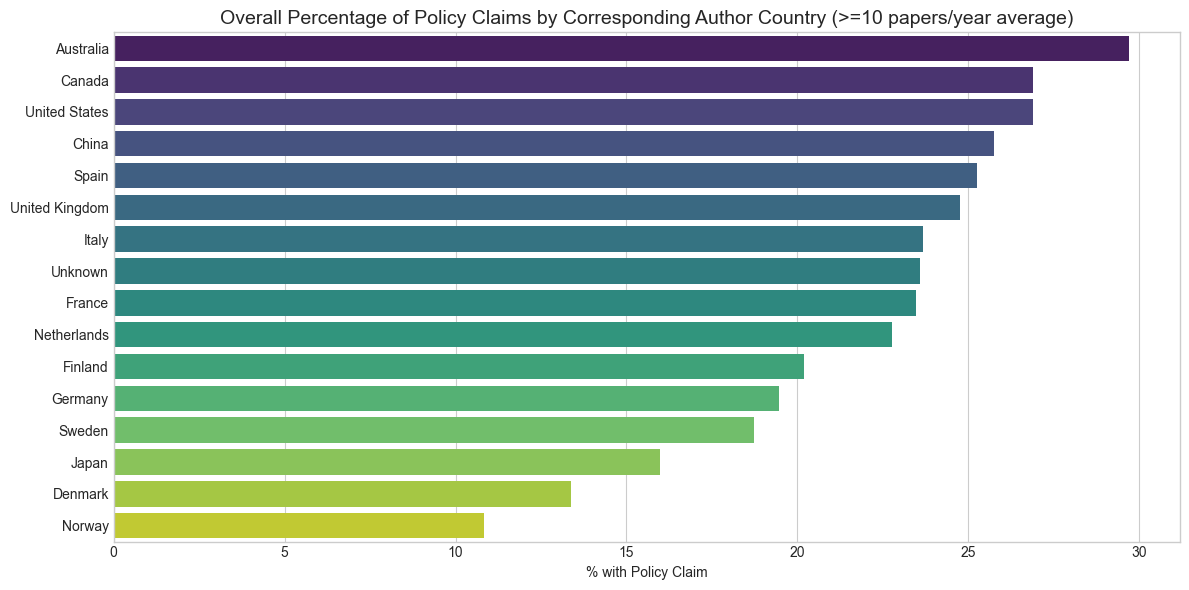

In [167]:
# Note (markdown cell):
# """
# ### Note on 'UNKNOWN' corresponding_author_country entries
# The dataset contains entries labelled 'UNKNOWN' for corresponding_author_country (these arise from missing or unclear values).
# These are ambiguous and are therefore excluded from the country-level analyses below.
# The code prints the total number of 'UNKNOWN' entries so you can inspect how many were removed.
# """

# Determine countries with at least 10 papers per year on average
# Compute country x year counts
counts_by_country_year = df.groupby(['corresponding_author_country', YEAR_COLUMN]).size().unstack(fill_value=0)
# Mean papers per year for each country
mean_per_year = counts_by_country_year.mean(axis=1)
# Compute UNKNOWN count and then select countries with mean >= 10, excluding 'UNKNOWN'
unknown_count = df['corresponding_author_country'].value_counts().get('UNKNOWN', 0)
eligible_countries = [c for c in mean_per_year[mean_per_year >= 10].index if c != 'UNKNOWN']
print(f"Countries with >=10 papers per year on average (excluding 'UNKNOWN'): {len(eligible_countries)}")
print(eligible_countries)
print(f"Number of 'UNKNOWN' corresponding_author_country entries removed from the analysis: {unknown_count}")

if len(eligible_countries) == 0:
    print('No countries meet the 10 papers/year threshold; skipping country-level analyses')
else:
    # Overall percentage of policy claims for eligible countries
    overall_country_rate = (
        df[df['corresponding_author_country'].isin(eligible_countries)]
        .groupby('corresponding_author_country')['claim']
        .mean()
        .reset_index()
    )
    plot_country_data = overall_country_rate.sort_values(by='claim', ascending=False)
    plot_country_data['percent_claim'] = plot_country_data['claim'] * 100

    plt.figure(figsize=(12, max(6, 0.3*len(plot_country_data))))
    sns.barplot(
        data=plot_country_data,
        x='percent_claim',
        y='corresponding_author_country',
        palette='viridis'
    )
    plt.title('Overall Percentage of Policy Claims by Corresponding Author Country (>=10 papers/year average)', fontsize=14)
    plt.xlabel('% with Policy Claim')
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig(FIGURE_DIR / "overall_percent_by_country_10peryear.png")
    plt.show()

    # # Use eligible countries for time-series
    # df_eligible = df[
    #     df['corresponding_author_country'].isin(eligible_countries)
    #     & (df['corresponding_author_country'] != 'Unknown')
    #     ]

    # --- 10-year rolling average percent plot by country ---
    # yearly_percent_country = (
    #     df_eligible.groupby([YEAR_COLUMN, 'corresponding_author_country'])['claim']
    #     .mean()
    #     .reset_index()
    # )
    # yearly_percent_country.rename(columns={'claim': 'percent_claim'}, inplace=True)
    # yearly_percent_country['percent_claim'] *= 100

    # pivot_country_10yr = yearly_percent_country.pivot(index=YEAR_COLUMN, columns='corresponding_author_country', values='percent_claim')
    # rolling_country_10yr = pivot_country_10yr.rolling(window=10, min_periods=1, center=True).mean()
    # smoothed_country_10yr = rolling_country_10yr.reset_index().melt(id_vars=YEAR_COLUMN, var_name='corresponding_author_country', value_name='smoothed_percent')

    # # Order legend by latest year
    # latest_year_c_10yr = smoothed_country_10yr[YEAR_COLUMN].max()
    # legend_order_c_10yr_df = smoothed_country_10yr[smoothed_country_10yr[YEAR_COLUMN] == latest_year_c_10yr].sort_values(by='smoothed_percent', ascending=False)
    # legend_order_c_10yr = legend_order_c_10yr_df['corresponding_author_country'].tolist()
    # smoothed_country_10yr['corresponding_author_country'] = pd.Categorical(smoothed_country_10yr['corresponding_author_country'], categories=legend_order_c_10yr, ordered=True)

    # plt.figure(figsize=(14, max(6, 0.4*len(legend_order_c_10yr))))
    # sns.lineplot(
    #     data=smoothed_country_10yr,
    #     x=YEAR_COLUMN,
    #     y='smoothed_percent',
    #     hue='corresponding_author_country',
    #     marker='o'
    # )
    # plt.title('10-Year Rolling Average of Policy Claim Percentage by Corresponding Author Country (Selected Countries)', fontsize=14)
    # plt.ylabel('% with Policy Claim (10-Year Rolling Avg)')
    # plt.xlabel('Publication Year')
    # plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.tight_layout()
    # plt.savefig(FIGURE_DIR / "yearly_percent_by_country_10yr_smoothed_selected.png")
    # plt.show()

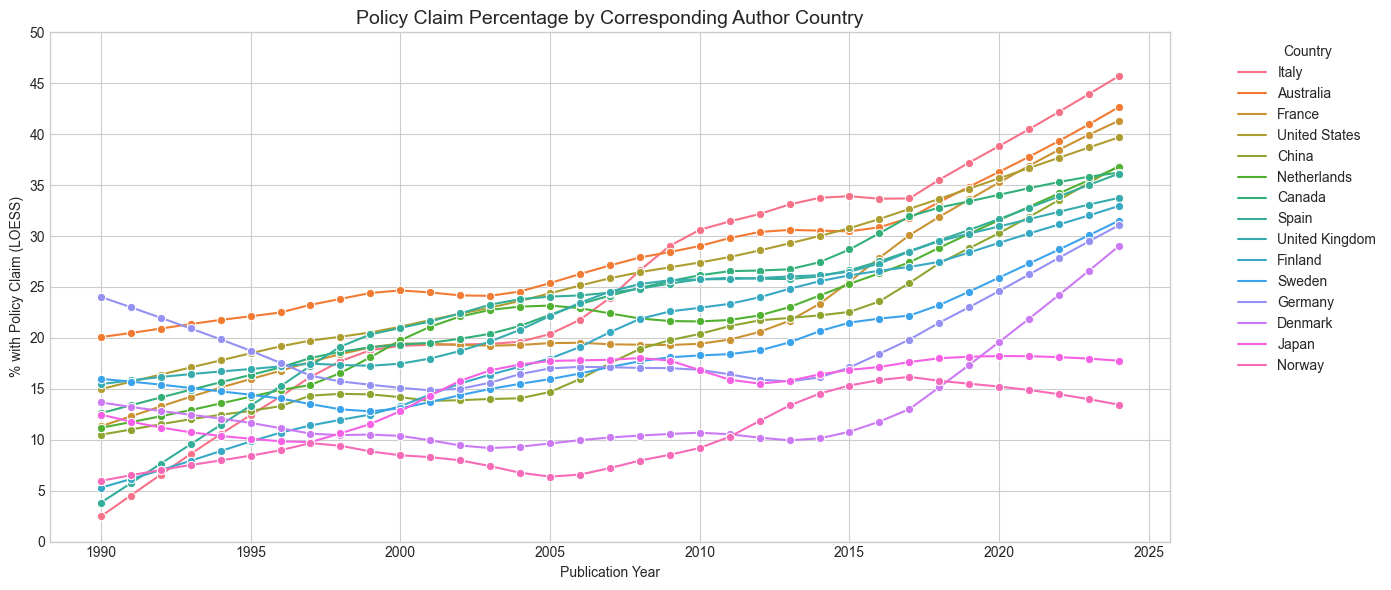

In [168]:
# --- 10-year rolling average percent plot by country 
yearly_percent_country = (
    df_eligible.groupby([YEAR_COLUMN, 'corresponding_author_country'])['claim']
    .mean()
    .reset_index()
)
yearly_percent_country.rename(columns={'claim': 'percent_claim'}, inplace=True)
yearly_percent_country['percent_claim'] *= 100

from statsmodels.nonparametric.smoothers_lowess import lowess

def _loess_group(d, frac=0.45):
    d = d.sort_values(YEAR_COLUMN).copy()
    d['smoothed_percent'] = lowess(d['percent_claim'], d[YEAR_COLUMN],
                                   frac=frac, it=1, return_sorted=False)
    return d

# Keep the same variable name so code below does not change
smoothed_country_10yr = (
    yearly_percent_country
    .groupby('corresponding_author_country', group_keys=False)
    .apply(_loess_group)
)

# Order legend by latest year (unchanged)
latest_year_c_10yr = smoothed_country_10yr[YEAR_COLUMN].max()
legend_order_c_10yr_df = (
    smoothed_country_10yr[smoothed_country_10yr[YEAR_COLUMN] == latest_year_c_10yr]
    .sort_values(by='smoothed_percent', ascending=False)
)
legend_order_c_10yr = legend_order_c_10yr_df['corresponding_author_country'].tolist()
smoothed_country_10yr['corresponding_author_country'] = pd.Categorical(
    smoothed_country_10yr['corresponding_author_country'],
    categories=legend_order_c_10yr, ordered=True
)

# Plot (only labels updated to reflect LOESS)
plt.figure(figsize=(14, max(6, 0.4*len(legend_order_c_10yr))))
sns.lineplot(
    data=smoothed_country_10yr,
    x=YEAR_COLUMN,
    y='smoothed_percent',
    hue='corresponding_author_country',
    marker='o'
)

from matplotlib.ticker import MultipleLocator
ax = plt.gca()
ax.set_ylim(0, 50)                       
ax.yaxis.set_major_locator(MultipleLocator(5)) 


plt.title('Policy Claim Percentage by Corresponding Author Country', fontsize=14)
plt.ylabel('% with Policy Claim (LOESS)')
plt.xlabel('Publication Year')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(FIGURE_DIR / "yearly_percent_by_country_10yr_smoothed_selected_maker.png")
plt.show()

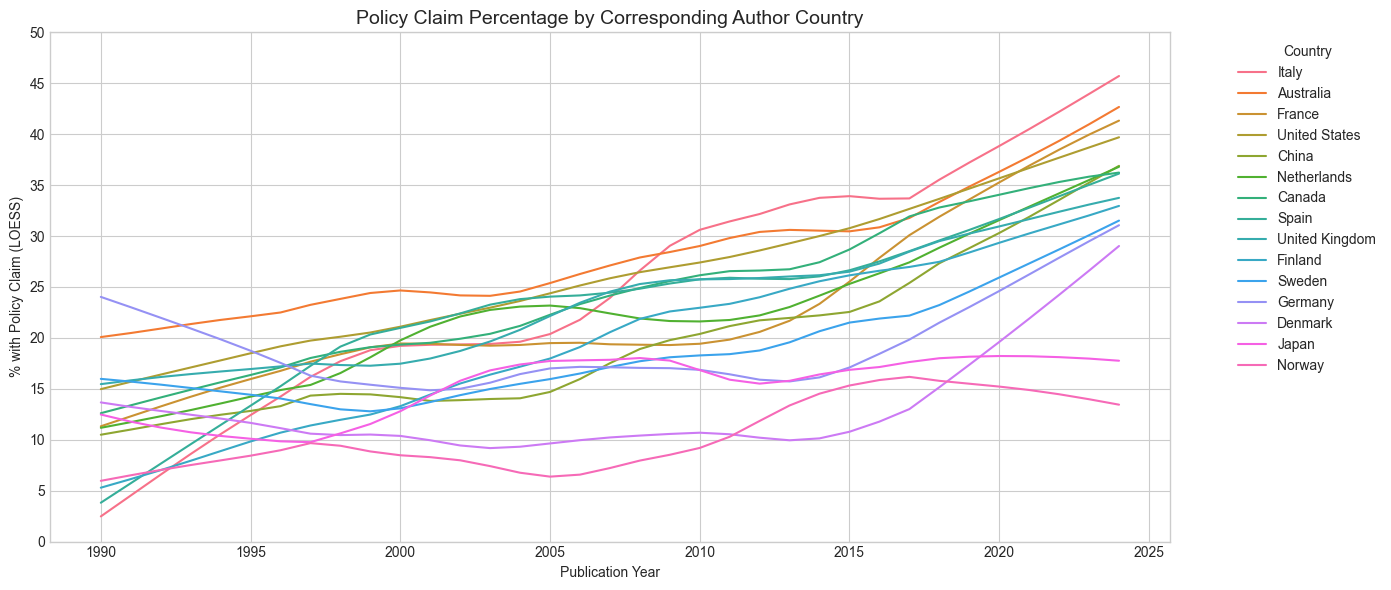

In [169]:
# --- 10-year rolling average percent plot by country 
yearly_percent_country = (
    df_eligible.groupby([YEAR_COLUMN, 'corresponding_author_country'])['claim']
    .mean()
    .reset_index()
)
yearly_percent_country.rename(columns={'claim': 'percent_claim'}, inplace=True)
yearly_percent_country['percent_claim'] *= 100

from statsmodels.nonparametric.smoothers_lowess import lowess

def _loess_group(d, frac=0.45):
    d = d.sort_values(YEAR_COLUMN).copy()
    d['smoothed_percent'] = lowess(d['percent_claim'], d[YEAR_COLUMN],
                                   frac=frac, it=1, return_sorted=False)
    return d

# Keep the same variable name so code below does not change
smoothed_country_10yr = (
    yearly_percent_country
    .groupby('corresponding_author_country', group_keys=False)
    .apply(_loess_group)
)

# Order legend by latest year (unchanged)
latest_year_c_10yr = smoothed_country_10yr[YEAR_COLUMN].max()
legend_order_c_10yr_df = (
    smoothed_country_10yr[smoothed_country_10yr[YEAR_COLUMN] == latest_year_c_10yr]
    .sort_values(by='smoothed_percent', ascending=False)
)
legend_order_c_10yr = legend_order_c_10yr_df['corresponding_author_country'].tolist()
smoothed_country_10yr['corresponding_author_country'] = pd.Categorical(
    smoothed_country_10yr['corresponding_author_country'],
    categories=legend_order_c_10yr, ordered=True
)

# Plot (only labels updated to reflect LOESS)
plt.figure(figsize=(14, max(6, 0.4*len(legend_order_c_10yr))))
sns.lineplot(
    data=smoothed_country_10yr,
    x=YEAR_COLUMN,
    y='smoothed_percent',
    hue='corresponding_author_country'
)

from matplotlib.ticker import MultipleLocator
ax = plt.gca()
ax.set_ylim(0, 50)                       
ax.yaxis.set_major_locator(MultipleLocator(5)) 


plt.title('Policy Claim Percentage by Corresponding Author Country', fontsize=14)
plt.ylabel('% with Policy Claim (LOESS)')
plt.xlabel('Publication Year')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(FIGURE_DIR / "yearly_percent_by_country_10yr_smoothed_selected.png")
plt.show()

## export ulate random selection of claims for manual checking

In [130]:
import pandas as pd

def sample_claim_abstracts(
    data: pd.DataFrame,
    n_per_journal: int = 5,
    start_year: int = 2020,
    end_year: int = 2024,
    seed: int = 123,
    require_exact: bool = False,
    journal_col: str = "journal",
    year_col: str = "publication_year",
    claim_col: str | None = None,
) -> pd.DataFrame:
    """
    Filter to [start_year, end_year] and claim==1/True, then sample up to
    n_per_journal per journal (exact if require_exact=True). Returns a new DataFrame.
    Assumes `data` is an in-memory DataFrame (no file I/O).
    """

    # Pick the claim column
    if claim_col is None:
        for cand in ("claim", "llm_policy_claim"):
            if cand in data.columns:
                claim_col = cand
                break
    if claim_col is None:
        raise ValueError("Need a 'claim' or 'llm_policy_claim' column (or pass claim_col=...).")

    # Column checks
    if journal_col not in data.columns:
        raise ValueError(f"Missing '{journal_col}' column.")
    if year_col not in data.columns:
        raise ValueError(f"Missing '{year_col}' column.")

    # Coerce year
    year = pd.to_numeric(data[year_col], errors="coerce")

    # Build a robust claim mask
    s = data[claim_col]
    if s.dtype == bool:
        claim_mask = s.fillna(False)
    else:
        s_num = pd.to_numeric(s, errors="coerce")
        if s_num.notna().any():
            claim_mask = (s_num == 1).fillna(False)
        else:
            claim_mask = s.astype(str).str.strip().str.lower().isin({"1", "true", "yes"})

    # Filter
    sub = data.loc[year.between(start_year, end_year, inclusive="both") & claim_mask].copy()
    if sub.empty:
        raise ValueError("No rows match filters (years and claim).")

    # Enforce availability if needed
    counts = sub[journal_col].value_counts()
    if require_exact:
        few = counts[counts < n_per_journal]
        if not few.empty:
            raise ValueError(
                "Journals with fewer than "
                f"{n_per_journal}: " + ", ".join(f"{j}({c})" for j, c in few.items())
            )

    # Sample per journal, deterministically
    sampled = (
        sub.groupby(journal_col, group_keys=False)
           .apply(lambda g: g.sample(n=min(len(g), n_per_journal), random_state=seed))
           .sample(frac=1, random_state=seed)  # shuffle final result
           .reset_index(drop=True)
    )

    return sampled


def sample_claim_abstracts_overall(
    data: pd.DataFrame,
    n_total: int = 100,
    start_year: int = 2020,
    end_year: int = 2024,
    seed: int = 123,
    year_col: str = "publication_year",
    claim_col: str | None = None,
) -> pd.DataFrame:
    """
    Filter to [start_year, end_year] and claim==1/True, then sample n_total
    abstracts regardless of journal. Returns a new DataFrame.
    """

    # Pick the claim column
    if claim_col is None:
        for cand in ("claim", "llm_policy_claim"):
            if cand in data.columns:
                claim_col = cand
                break
    if claim_col is None:
        raise ValueError("Need a 'claim' or 'llm_policy_claim' column (or pass claim_col=...).")

    # Column checks
    if year_col not in data.columns:
        raise ValueError(f"Missing '{year_col}' column.")

    # Coerce year
    year = pd.to_numeric(data[year_col], errors="coerce")

    # Build a robust claim mask
    s = data[claim_col]
    if s.dtype == bool:
        claim_mask = s.fillna(False)
    else:
        s_num = pd.to_numeric(s, errors="coerce")
        if s_num.notna().any():
            claim_mask = (s_num == 1).fillna(False)
        else:
            claim_mask = s.astype(str).str.strip().str.lower().isin({"1", "true", "yes"})

    # Filter
    sub = data.loc[year.between(start_year, end_year, inclusive="both") & claim_mask].copy()
    if sub.empty:
        raise ValueError("No rows match filters (years and claim).")

    # Sample overall (random selection across all journals)
    sampled = sub.sample(n=min(len(sub), n_total), random_state=seed).reset_index(drop=True)

    return sampled

In [131]:
import json
import numpy as np

# 1) Sample
sampled_by_journal = sample_claim_abstracts(df, n_per_journal=5, start_year=2020, end_year=2024, seed=123)
sampled_overall  = sample_claim_abstracts_overall(df, n_total=100, start_year=2020, end_year=2024, seed=123)

# 2) Choose column order (fallback to all if missing)
preferred = ["journal","publication_year","title","abstract","keywords","doi","pmid","claim","llm_policy_claim"]
cols_j = [c for c in preferred if c in sampled_by_journal.columns] or sampled_by_journal.columns.tolist()
cols_o = [c for c in preferred if c in sampled_overall.columns] or sampled_overall.columns.tolist()

def prep_for_csv(x):
    if isinstance(x, (list, tuple, np.ndarray)):
        return ", ".join(map(str, x))
    if isinstance(x, dict):
        return json.dumps(x, ensure_ascii=False)
    return x

# 3) Clean + export
out_j = sampled_by_journal[cols_j].copy()
out_o = sampled_overall[cols_o].copy()
out_j.columns = [str(c) for c in out_j.columns]
out_o.columns = [str(c) for c in out_o.columns]
for c in out_j.columns: out_j[c] = out_j[c].apply(prep_for_csv)
for c in out_o.columns: out_o[c] = out_o[c].apply(prep_for_csv)

for df_out, fn in [
    (out_j, "../table/supp_sampled_policy_claims_by_journal_2020_2024.csv"),
    (out_o, "../table/supp_sampled_policy_claims_overall_2020_2024.csv"),
]:
    with open(fn, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow([str(c) for c in df_out.columns])
        w.writerows(df_out.astype(str).to_numpy())

## regular expression analyses/plot

Detecting bold policy claims in abstracts...
✓ Total abstracts: 45,807
✓ Abstracts with bold policy claims: 186
✓ Percentage with claims: 0.41%



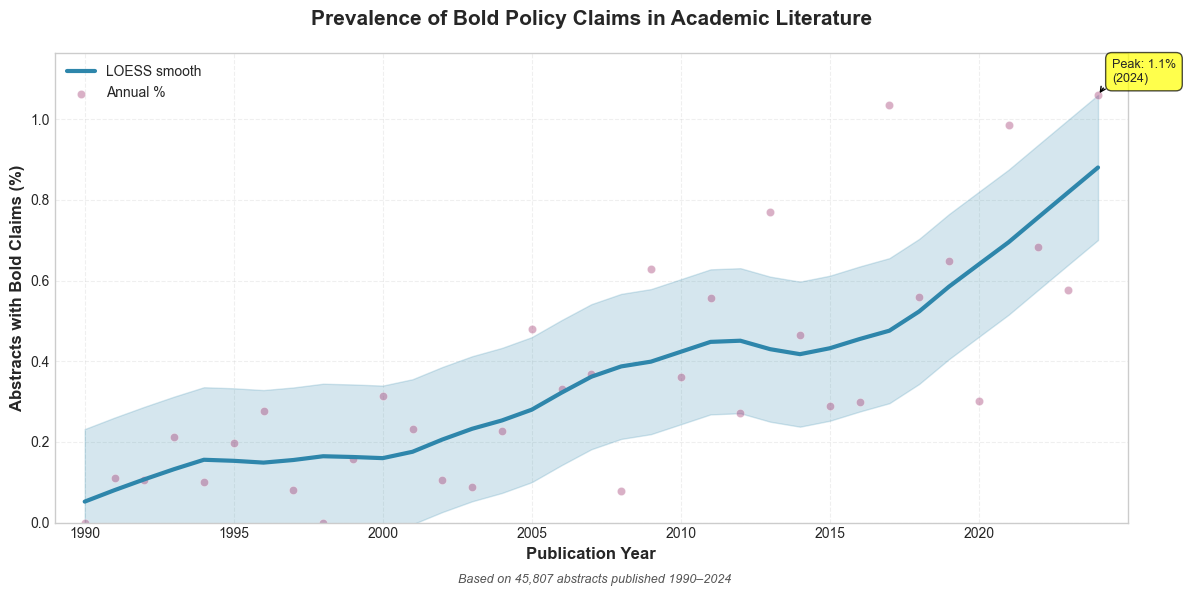


✓ Improved figure saved to: /Users/wangmengyao/Desktop/policyclaims/figures/bold_policy_claims_improved.png

Key improvements:
  • Cleaner x-axis with 5-year intervals
  • Y-axis starts at 0 for accurate perception
  • Trend line more prominent than scatter
  • Sample size info moved to subtitle
  • Higher resolution (300 dpi)
  • Better color scheme and visual hierarchy


In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re

# Try to use true LOWESS from statsmodels; fallback to rolling mean if unavailable
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    HAS_SM = True
except Exception:
    HAS_SM = False

# === POLICY CLAIM DETECTION (MISSING PART) ===

TERMS_TO_ANALYZE = {
    "policy_claim_via_terms": [
        r"policies?\s+should",
        r"policymakers?\s+should",
        r"government\s+(must|should)",
        r"policy\s+(changes?|reforms?)\s+are\s+(needed|required|necessary)",
        r"we\s+(call\s+for|recommend|urge)\s+policy",
        r"we\s+call\s+(on|upon)\s+policymakers",
        r"we\s+call\s+for\s+government\s+action",
        r"(urgent|important)\s+need\s+for\s+policy\s+(action|change|reform)",
        r"interventions?\s+should\s+(focus|target|address|prioritize)",
        r"public\s+health\s+interventions?\s+should",
        r"policy\s+interventions?\s+(are\s+necessary|should\s+be\s+implemented)",
        r"(existing|current)\s+policies?\s+(are|is)\s+(inadequate|insufficient|outdated)",
        r"policy\s+has\s+(failed|not\s+been\s+effective)",
        r"policy\s+is\s+(failing|ineffective|inadequate)",
        r"policy\s+should\s+be\s+(reversed|changed|improved|strengthened)",
        r"policy\s+must\s+align\s+with\s+(scientific|ethical)\s+principles",
        r"policy\s+should\s+(prioritize|focus\s+on|address)",
        r"government\s+has\s+(a\s+duty|an\s+obligation)\s+to\s+implement\s+policy",
        r"government\s+should\s+(enact|pass|implement|fund)\s+policies?",
        r"legislation\s+must\s+be\s+introduced\s+to\s+(address|tackle)",
        r"(findings|results|study)\s+should\s+inform\s+policy",
        r"this\s+study\s+(shows|demonstrates|indicates)\s+(the\s+need|a\s+need)\s+for\s+policy\s+change",
        r"our\s+results\s+(support|justify|warrant)\s+policy\s+interventions",
        r"regulatory\s+framework\s+(should|must|needs\s+to)\s+be\s+(changed|revised)",
        r"stronger\s+policies\s+are\s+needed",
        r"public\s+health\s+policy\s+should\s+address",
        r"action\s+is\s+needed\s+to\s+(change|reform|improve)\s+policy",
        r"tax(ation)?\s+(policies?|measures?|reforms?)\s+(should|must|needs?\s+to)\s+be",
        r"tax(es)?\s+should\s+be\s+(raised|lowered|implemented|introduced|reconsidered)",
        r"tax\s+incentives?\s+(are|is)\s+(needed|required|necessary)",
        r"(sin|sugar|tobacco|alcohol|carbon)\s+tax(es)?\s+should\s+be\s+(implemented|increased|considered)",
        r"legal\s+framework\s+(should|must|needs\s+to)\s+be\s+(established|changed|revised)",
        r"(laws?|regulations?|rules?)\s+should\s+be\s+(changed|revised|strengthened|enacted)",
        r"(legal|regulatory)\s+changes?\s+are\s+(needed|necessary|required)",
        r"legislative\s+action\s+is\s+(needed|required|necessary)",
        r"(is|are)\s+a\s+need\s+for\s+(policy|legislative|regulatory|government)\s+(action|intervention|reform)",
        r"(clear|strong|compelling)\s+case\s+for\s+(policy|government)\s+intervention",
        r"action\s+is\s+needed",
        r"(there\s+is|it\s+is)\s+time\s+to\s+(implement|change|reconsider)\s+policies?",
        r"government\s+interventions?\s+(are|is)\s+(needed|necessary|required)",
        r"government\s+should\s+(regulate|intervene|act)",
        r"(national|state|federal|local)\s+policies?\s+should",
        r"public\s+policy\s+(must|should|needs\s+to)",
        r"(mandate|mandates|mandating|mandatory)\s+(are|is|should\s+be)\s+(needed|necessary|required|implemented)",
        r"(require|requires|requiring|requirements)\s+(are|is|should\s+be)\s+(needed|necessary|implemented)",
        r"(ban|bans|banning|banned)\s+on\s+.+\s+should\s+be\s+considered",
        r"(health\s+(system|care|policy|insurance)\s+(reform|changes?)\s+(are|is)\s+(needed|necessary|required))",
        r"health\s+system\s+should\s+be\s+(reformed|changed|improved)",
        r"(social|economic|welfare|housing|education)\s+policies?\s+should",
        r"(social|economic|welfare)\s+policy\s+reforms?\s+(are|is)\s+(needed|necessary|required)",
        r"(critical|essential|imperative|necessary|important)\s+that\s+.+(policy|government|policymakers)",
        r"(urgent|pressing|important)\s+(need|call)\s+for\s+(action|change|reform|intervention)",
        r"policy\s+efforts?\s+should\s+focus\s+on",
    ]
}

def detect_bold_policy_claims(text):
    """
    Detect bold policy claims in text based on predefined patterns.
    Returns True if any pattern matches, False otherwise.
    """
    if pd.isna(text) or not isinstance(text, str):
        return False
    
    text_lower = text.lower()
    
    # Check each pattern
    for pattern in TERMS_TO_ANALYZE["policy_claim_via_terms"]:
        if re.search(pattern, text_lower):
            return True
    
    return False

# Apply detection to the abstract field
print("Detecting bold policy claims in abstracts...")
df['bold_policy_claim'] = df['abstract'].apply(detect_bold_policy_claims)

print(f"✓ Total abstracts: {len(df):,}")
print(f"✓ Abstracts with bold policy claims: {df['bold_policy_claim'].sum():,}")
print(f"✓ Percentage with claims: {100 * df['bold_policy_claim'].mean():.2f}%\n")

# === CREATE YEARLY AGGREGATION ===

tmp = df.copy()
tmp["publication_year"] = pd.to_numeric(tmp["publication_year"], errors="coerce")
tmp = tmp.dropna(subset=["publication_year"])
tmp["publication_year"] = tmp["publication_year"].astype(int)

yearly = (
    tmp.groupby("publication_year", as_index=False)
       .agg(n=("bold_policy_claim", "size"),
            n_claim=("bold_policy_claim", "sum"))
)
yearly["pct_claim"] = 100 * yearly["n_claim"] / yearly["n"]

# Ensure sorted by year
yearly = yearly.sort_values("publication_year").reset_index(drop=True)

x = yearly["publication_year"].to_numpy()
y = yearly["pct_claim"].to_numpy()

# === SMOOTH ===
if HAS_SM:
    smoothed = lowess(y, x, frac=0.3, it=2, return_sorted=True)
    xs, ys = smoothed[:, 0], smoothed[:, 1]
else:
    s = pd.Series(y, index=x).sort_index()
    full_index = np.arange(int(x.min()), int(x.max()) + 1)
    s_full = s.reindex(full_index).interpolate()
    ys = s_full.rolling(window=5, center=True, min_periods=1).mean().to_numpy()
    xs = full_index

# === CREATE IMPROVED PLOT ===
fig, ax = plt.subplots(figsize=(12, 6))

# Trend line first (more prominent), thicker
ax.plot(xs, ys, linewidth=3, color='#2E86AB', 
        label="LOESS smooth" if HAS_SM else "5-year rolling mean", zorder=3)

# Scatter points smaller, more transparent, behind trend
ax.scatter(x, y, s=35, alpha=0.4, color='#A23B72', 
          edgecolors='white', linewidth=0.5, label="Annual %", zorder=2)

# Add shaded confidence band to show trend uncertainty
if HAS_SM and len(x) > 10:
    residuals = np.interp(x, xs, ys) - y
    std_resid = np.std(residuals)
    ax.fill_between(xs, ys - std_resid, ys + std_resid, 
                     alpha=0.2, color='#2E86AB', zorder=1)

# Better title and labels
ax.set_title("Prevalence of Bold Policy Claims in Academic Literature", 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xlabel("Publication Year", fontsize=12, fontweight='600')
ax.set_ylabel("Abstracts with Bold Claims (%)", fontsize=12, fontweight='600')

# Cleaner grid
ax.grid(True, linestyle='--', alpha=0.3, linewidth=0.8)
ax.set_axisbelow(True)

# Better x-axis (every 5 years)
year_min, year_max = int(x.min()), int(x.max())
ax.set_xlim(year_min - 1, year_max + 1)
ax.set_xticks(range(year_min, year_max + 1, 5))

# Y-axis starts at 0 for proper scale perception
ax.set_ylim(0, max(y.max(), ys.max()) * 1.1)

# Legend with better positioning
ax.legend(loc='upper left', framealpha=0.95, fontsize=10)

# Add sample size info as subtitle
total_abstracts = yearly["n"].sum()
year_range = f"{year_min}–{year_max}"
fig.text(0.5, 0.02, f"Based on {total_abstracts:,} abstracts published {year_range}", 
         ha='center', fontsize=9, style='italic', color='#555')

# Add subtle annotation for key insight
max_pct_idx = y.argmax()
max_year = x[max_pct_idx]
max_pct = y[max_pct_idx]
if max_pct > 0.8:  # Only annotate if notable
    ax.annotate(f'Peak: {max_pct:.1f}%\n({int(max_year)})', 
                xy=(max_year, max_pct), xytext=(10, 10),
                textcoords='offset points', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3'))

plt.tight_layout(rect=[0, 0.03, 1, 1])

# Save figure
try:
    FIGURE_DIR
except NameError:
    FIGURE_DIR = Path("figures")
FIGURE_DIR.mkdir(parents=True, exist_ok=True)

out_file = FIGURE_DIR / "bold_policy_claims_improved.png"
plt.savefig(out_file, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✓ Improved figure saved to: {out_file.resolve()}")
print(f"\nKey improvements:")
print(f"  • Cleaner x-axis with 5-year intervals")
print(f"  • Y-axis starts at 0 for accurate perception")
print(f"  • Trend line more prominent than scatter")
print(f"  • Sample size info moved to subtitle")
print(f"  • Higher resolution (300 dpi)")
print(f"  • Better color scheme and visual hierarchy")


Sensitivity (last-5-year weighted means):
Regex (all):              0.73%
Regex (exclude methods):  0.73%
LLM (all):                35.82%
LLM (exclude methods):    36.36%


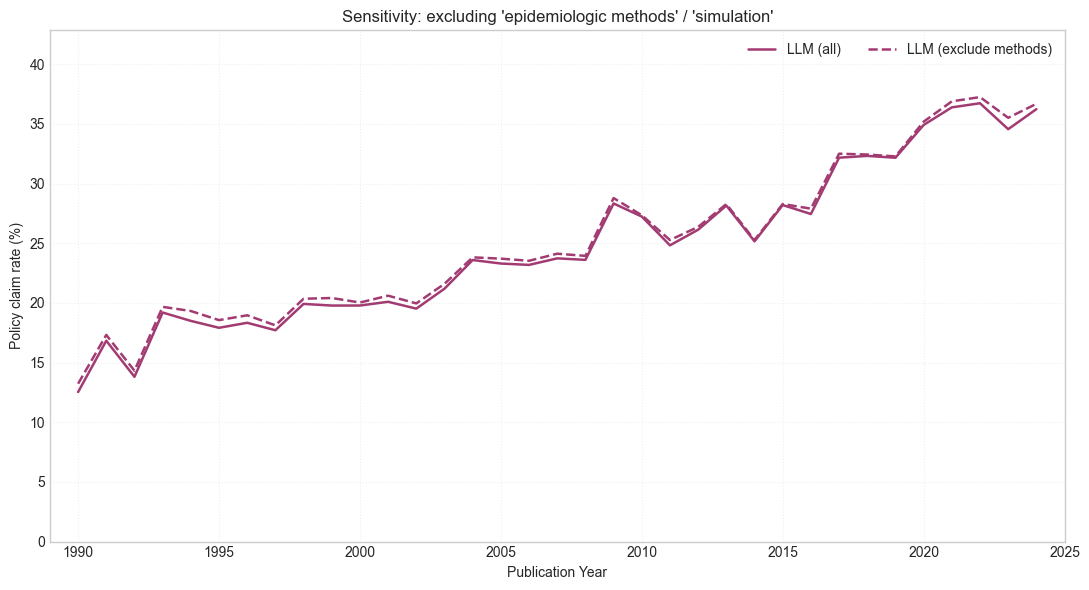

In [133]:
# ---------------- Sensitivity analyses (append after the code above) ----------------
# 1) Exclude likely methodological abstracts (title/keywords contain 'epidemiologic methods' or 'simulation')
meth_pat = r"(epidemiologic methods|simulation)"
meth_mask = (
    df['title'].astype(str).str.lower().str.contains(meth_pat, na=False) |
    df['keywords'].astype(str).str.lower().str.contains(meth_pat, na=False)
)

def yearly_pct(d, col):
    d = d.copy()
    d["publication_year"] = pd.to_numeric(d["publication_year"], errors="coerce")
    d = d.dropna(subset=["publication_year"])
    d["publication_year"] = d["publication_year"].astype(int)
    out = (d.groupby("publication_year", as_index=False)
             .agg(n=(col, "size"), n_claim=(col, "sum")))
    out["pct"] = 100 * out["n_claim"] / out["n"]
    return out.sort_values("publication_year")

# Regex-based (bold) claims: all vs. excluding methodological
yr_all_regex  = yearly_pct(df, "bold_policy_claim")
yr_excl_regex = yearly_pct(df[~meth_mask], "bold_policy_claim")

# Optional: LLM-based trend for triangulation (if available)
yr_all_llm = yearly_pct(df, "llm_policy_claim") if "llm_policy_claim" in df.columns else None
yr_excl_llm = yearly_pct(df[~meth_mask], "llm_policy_claim") if "llm_policy_claim" in df.columns else None

# Plot overlay: regex (all vs. excl. methods) + optional LLM
fig, ax = plt.subplots(figsize=(11, 6))
if yr_all_llm is not None:
    ax.plot(yr_all_llm["publication_year"], yr_all_llm["pct"], color="#A23B72", lw=1.8, label="LLM (all)")
if yr_excl_llm is not None:
    ax.plot(yr_excl_llm["publication_year"], yr_excl_llm["pct"], color="#A23B72", lw=1.8, ls="--", label="LLM (exclude methods)")
ymax_list = [yr_all_regex["pct"].max(), yr_excl_regex["pct"].max()]
for s in (yr_all_llm, yr_excl_llm):
    if s is not None and len(s):
        ymax_list.append(s["pct"].max())

ymax = max(ymax_list)
ax.set_ylim(0, ymax * 1.15)
ax.set_xlabel("Publication Year"); ax.set_ylabel("Policy claim rate (%)")
ax.set_title("Sensitivity: excluding 'epidemiologic methods' / 'simulation'")
ax.set_xlim(min(yr_all_regex["publication_year"])-1, max(yr_all_regex["publication_year"])+1)
ax.grid(True, ls=":", alpha=0.3); ax.legend(frameon=False, ncol=2)
plt.tight_layout()
plt.savefig(FIGURE_DIR / "policy_claims_sensitivity_regex_llm.png", dpi=300, bbox_inches="tight")

# Quick text summary (last 5 years mean)
def last5_mean(df_yr): 
    tail = df_yr.tail(5)
    return np.average(tail["pct"], weights=tail["n"]) if len(tail) else np.nan

print("\nSensitivity (last-5-year weighted means):")
print(f"Regex (all):              {last5_mean(yr_all_regex):.2f}%")
print(f"Regex (exclude methods):  {last5_mean(yr_excl_regex):.2f}%")
if yr_all_llm is not None:
    print(f"LLM (all):                {last5_mean(yr_all_llm):.2f}%")
if yr_excl_llm is not None:
    print(f"LLM (exclude methods):    {last5_mean(yr_excl_llm):.2f}%")

In [134]:
print(len(pd.read_csv("../data/json_files/excluded_records.csv")))

13817
